# Opdracht 2 - Convolutional Neural Networks


Het doel van deze opdracht is om image recognition te doen aan de hand van Convolutional Neural Networks (CNN). In een eerste deelopdracht ontwerp je een binaire CNN classifier voor het classificeren van foto's van lichaamscellen die al dan niet met malaria geïnfecteerd zijn. 

In een tweede deelopdracht zal je gezichtsherkenning uitvoeren via een multi-class CNN classifier.

In een derde deelopdracht train je een CNN die gezichten van niet-gezichten kan onderscheiden. Met deze classifier kan je vervolgens gezichtsdetectie uitvoeren. Daarbij is het niet de bedoeling om gezichten te herkennen, maar de locatie van al dan niet aanwezig gezichten in afbeeldingen te vinden en aan te duiden.

Na deze opdracht zal je vertrouwd zijn met:
- Implementeren van convolutional neural networks voor objectherkenning in afbeeldingen.
- Hyperparameter tuning van CNN's
- Weten hoe je transfer learning kan toepassen voor jouw eigen classificatie taak.
- Data/Image augmentation uitvoeren.
- Object detectie via een sliding window.


In [1]:
%matplotlib inline
import os
from pathlib import Path
from datetime import datetime
import pytz
import time
from datetime import datetime
import re
import shutil

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Graphics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from termcolor import (
    colored,
    cprint,
)
import matplotlib.image as mpimg
from skimage.io import imread, imshow

# Data
import numpy as np
import pandas as pd

# SKLearn
from sklearn.datasets import (
    make_blobs,
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelBinarizer,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    auc,
    roc_curve,
    RocCurveDisplay,
)

from sklearn.utils import (
    class_weight,
    shuffle,
)

from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import sklearn.metrics as metrics
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Conv2D, 
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input, 
    MaxPooling2D,
    Rescaling,
    ZeroPadding2D,
)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import (
    relu,
    leaky_relu,
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Some defaults for matplotlib
LARGE = 12
MEDIUM = 10
SMALL = 6
plt.tight_layout()
plt.rcParams.update({
    'axes.titlesize': MEDIUM,
    'legend.fontsize': SMALL,
    'figure.figsize': (5, 3),
    'axes.labelsize': MEDIUM,
    'axes.titlesize': MEDIUM,
    'xtick.labelsize': SMALL,
    'ytick.labelsize': SMALL,
    'figure.titlesize': LARGE
})

# Reproducibility of the results
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

###### Voor Tensorflow-GPU ########
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)


2025-05-13 08:34:16.557132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 08:34:16.574672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747118056.590397   90079 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747118056.597089   90079 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 08:34:16.616839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<Figure size 640x480 with 0 Axes>

### Display info

In [2]:
# Display Helpers
def display_title(title, value=None):
    if value is None:
        cprint(title, "black", "on_cyan")
    else:
        print(colored(title, "blue"))
        print(value)

def display_value(title, value):
    print(f"{colored(title, "blue")}: {value}")


### Metrics

In [3]:
# Metrics
def print_metrics(model, X_test, y_test, title="Results"):
    display_title(title)
    y_pred_proba = model.predict(X_test)
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    display_title("classification report", classification_report(y_test, y_pred_class))
    display_title("confusion matrix", confusion_matrix(y_test, y_pred_class))
    display_value("Accuracy score", (accuracy_score(y_test, y_pred_class) * 100))


### Information Plots

## Malaria Classification

Ontwerp en train een CNN dat is in staat is met Malaria geïnfecteerde cellen van niet-geïnfecteerde cellen te onderscheiden.

De data is te vinden in:
- './Malaria/train/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te trainen.
- './Malaria/train/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te trainen.
- './Malaria/test/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te testen.
- './Malaria/test/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te testen.


1. Ontwerp in eerste instantie een eigen CNN. 
- Probeer de accuracy van het CNN op de test data zo hoog mogelijk te krijgen. Dit kan bijvoorbeeld omvatten: hyperparameter tuning van de het netwerk zelf, early stopping, image augmentation of eigen bedachte (pre)-processing technieken. 
- Stel nu dat aan het CNN de vereiste wordt gesteld dat het aantal false negatives (het netwerk voorspelt niet-geïnfecteerd terwijl ze wel geïnfecteerd zijn) op de test set maximaal 1% mag bedragen. Welke aanpassingen zou je doen? Voor deze aanpassingen uit en toon aan dat het aantal false negatives tot maximum 1% is gezakt. Welke accuracy haal je nog?

2. Voer transfer learning uit. Hertrain het VGG19 netwerk voor het classificeren van de al dan niet met Malaria geïnfecteerde cellen. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.



In [4]:
# Plotting
# TODO: Hier zou ik ook alle metrics kunnen plotten
def plot_history(history, training_time, title="Results"):
    """Plot error and accuracy of model.fit """
    print("--->",history.history.keys()) 
    if "false_negatives_50pct" in history.history.keys():
        fig, axes = plt.subplots(1, 3, figsize = (18, 3), sharey=False)
    else:
        fig, axes = plt.subplots(1, 2, figsize = (12, 3), sharey=False)

    # Loss (Training error)
    axes[0].set_title("Loss")
    axes[0].plot(history.epoch, history.history["loss"], "red", linewidth=2.0, label="training loss")
    axes[0].plot(history.epoch, history.history['val_loss'],'blue',linewidth=2.0, label="validation loss")
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].grid()
    axes[0].legend(loc='upper right')
    
    # Accuracy
    if "accuracy" in history.history.keys():
        key = "accuracy"
    if "binary_accuracy" in history.history.keys():
        key = "binary_accuracy"
        
    axes[1].set_title("Accuracy")
    axes[1].plot(history.epoch, history.history[key], "red", linewidth=2.0, label=f"training {key}")
    axes[1].plot(history.epoch, history.history[f"val_{key}"],'blue',linewidth=2.0, label=f"validation {key}")
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel(key)
    axes[1].grid()
    axes[1].legend(loc="lower right")

    if "false_negatives_50pct" in history.history.keys():
        axes[2].set_title("False Negatives")
        axes[2].plot(history.epoch, history.history["false_negatives_50pct"], "red", linewidth=1.5, linestyle="dashed", label="training False Negatives 0.5")
        axes[2].plot(history.epoch, history.history["val_false_negatives_50pct"],'blue',linewidth=1.5, linestyle="dashed", label="validation False Negatives 0.5")
        if "false_negatives_99pct" in history.history.keys():
            axes[2].plot(history.epoch, history.history["false_negatives_99pct"], "red", linewidth=1.5, label="training False Negatives 0.99")
            axes[2].plot(history.epoch, history.history["val_false_negatives_99pct"],'blue',linewidth=1.5, label="validation False Negatives 0.99")
        axes[2].set_xlabel("epoch")
        axes[2].set_ylabel("false negatives")
        axes[2].grid()
        axes[2].legend(loc="upper right")
        
    # Overall title
    fig.suptitle(f"{title}: ({training_time:.5f})", verticalalignment="top")

    # show
    plt.show()

### Eigen CNN (exploratie)

In [5]:
# Inlezen van de data
# Reading images
def read_images(path, nbr_images, image_size, label):
    valid_image_extensions = [".jpg", ".gif", ".png"]
    selected_images = []
    labels = []
    nbr_of_images_collected = 0
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_image_extensions:
            continue
        if nbr_of_images_collected >= nbr_images:
            break
        im = imread(os.path.join(path, f))
        im = transform.resize(im, (image_size, image_size), mode='constant', anti_aliasing=True)
        selected_images.append(im)
        labels.append(label)
        nbr_of_images_collected = nbr_of_images_collected+1

    return selected_images, labels
    
# Creëer een training set en test set. Zorg ervoor dat 30 procent van de afbeeldingen in de test set zitten.
def read_malaria_input(sample_size=1000, image_size=100):
    ROOT_PATH = Path("")

    infected_train_images, y_infected_train = read_images(ROOT_PATH / "./Malaria/train/infected", sample_size, image_size, 1)
    infected_test_images, y_infected_test = read_images(ROOT_PATH / "./Malaria/test/infected", sample_size, image_size, 1)
    uninfected_train_images, y_uninfected_train = read_images(ROOT_PATH / "./Malaria/train/uninfected", sample_size, image_size, 0)
    uninfected_test_images, y_uninfected_test = read_images(ROOT_PATH / "./Malaria/test/uninfected",sample_size, image_size, 0)
    display_title("Infected == 1 and Uninfected == 0")

    # collect some sample images to display
    samples_infected = [infected_train_images[0], infected_test_images[4]]
    samples_uninfected = [uninfected_train_images[0], uninfected_test_images[4]]

    # Mix de infected en niet infected
    X_train, y_train = shuffle(uninfected_train_images + infected_train_images,  y_uninfected_train + y_infected_train, random_state=0)
    X_test, y_test = shuffle(uninfected_test_images + infected_test_images,  y_uninfected_test + y_infected_test, random_state=1)

    # convert to numpy arrays
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    print(type(X_train), y_train[0:20])
    return X_train, y_train, X_test, y_test, samples_infected, samples_uninfected
    
# Input sizes
image_size = 50                      # hoogte en breedte van de afbeeldingen na resizing. Pas gerust aan.
nr_train_images_per_category = 2000  # Om het aantal afbeelding in de training set te beperken. Verhoog indien jouw systeem het toelaat.
                                     # om het eenvoudig te houden nemen we evenveel test als train images

# read the imnages
X_train, y_train, X_test, y_test, samples_infected, samples_uninfected = read_malaria_input(sample_size=nr_train_images_per_category, image_size=image_size)
display_value(f"X_train shape", X_train.shape)    
display_value(f"y_train shape", y_train.shape)    
display_value(f"X_test shape", X_train.shape)    
display_value(f"y_test shape", y_train.shape)    
display("")
display_value(f"sample y_train {type(y_train)}", y_train[0:20])    
display_value(f"sample y_test {type(y_test)}", y_test[0:20])    
    


Infected == 1 and Uninfected == 0
<class 'numpy.ndarray'> [1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1]
X_train shape: (4000, 50, 50, 3)
y_train shape: (4000,)
X_test shape: (4000, 50, 50, 3)
y_test shape: (4000,)


''

sample y_train <class 'numpy.ndarray'>: [1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1]
sample y_test <class 'numpy.ndarray'>: [0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0]


Text(0.5, 0.98, '50x50')

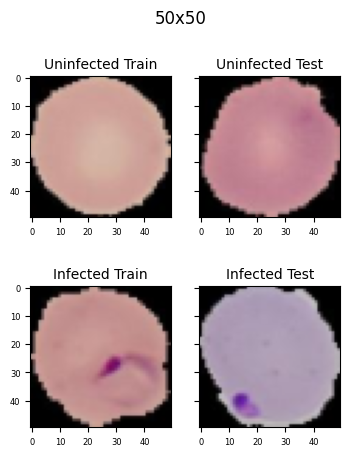

In [6]:
# Toon een aantal afbeeldingen afbeelding
fig_vb, axes_vb = plt.subplots(2, 2, figsize = (4, 5), sharey=True)
axes_vb[0,0].set_title("Uninfected Train")
axes_vb[0,0].imshow(samples_uninfected[0])
axes_vb[0,1].set_title("Uninfected Test")
axes_vb[0,1].imshow(samples_uninfected[1])
axes_vb[1,0].set_title("Infected Train")
axes_vb[1,0].imshow(samples_infected[0])
axes_vb[1,1].set_title("Infected Test")
axes_vb[1,1].imshow(samples_infected[1])
fig_vb.suptitle(f"{image_size}x{image_size}")


In [7]:
# Normalisatie van de data
display_value("example image shape", X_train[0].shape)
display_value("min in an image", np.amin(X_train[0]))
display_value("max in an image", np.amax(X_train[0]))
display_value("min all training images", np.amin(X_train))
display_value("max all images", np.amax(X_train))
# De data lijkt reeds genormaliseerd te zijn


example image shape: (50, 50, 3)
min in an image: 0.0
max in an image: 0.8852432762662961
min all training images: 0.0
max all images: 0.9958680811571734


In [8]:
# CNN Architecture
def build_malaria_model(input_shape=(100, 100, 3), with_pre_processing=False):
    # Model
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # Preprocessing
    if with_pre_processing:
        model.add(Reshape(target_shape=(50,50,3)))
        model.add(Rescaling(scale=1.0/255.0, offset=0.0))

    # Feature Extraction Layers
    # Strides=(1,1), padding="valid"
    model.add(Conv2D(filters=16, kernel_size=(3, 3)))
    model.add(Activation(tf.keras.activations.relu))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, kernel_size=(3, 3)))
    model.add(Activation(tf.keras.activations.relu))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation(tf.keras.layers.ReLU(negative_slope=0.0)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation(tf.keras.layers.ReLU(negative_slope=0.0)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Prepare for classification
    model.add(Flatten())

    # Classification Layers
    model.add(Dense(units=64))
    model.add(Activation('relu'))  # Explicit activation
    model.add(BatchNormalization())

    model.add(Dense(units=32))
    model.add(Activation('relu'))  # Explicit activation
    model.add(BatchNormalization())

    # Add an output layer for binary classification
    model.add(Dense(units=1))  # Single unit for binary classification
    model.add(Activation('sigmoid'))

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        # metrics=['accuracy'],
        metrics=[
            # tf.keras.metrics.Accuracy(),
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.TrueNegatives(thresholds=0.5, name="true_negatives_50pct"),
            tf.keras.metrics.TruePositives(thresholds=0.5, name="true_positives_50pct"),
            tf.keras.metrics.FalseNegatives(thresholds=0.5, name="false_negatives_50pct"),
            tf.keras.metrics.FalsePositives(thresholds=0.5, name="false_positives_50pct"),
            tf.keras.metrics.TrueNegatives(thresholds=0.99, name="true_negatives_99pct"),
            tf.keras.metrics.TruePositives(thresholds=0.99, name="true_positives_99pct"),
            tf.keras.metrics.FalseNegatives(thresholds=0.99, name="false_negatives_99pct"),
            tf.keras.metrics.FalsePositives(thresholds=0.99, name="false_positives_99pct"),
        ],
    )
    return model

malaria_model = build_malaria_model(input_shape=(image_size, image_size, 3))
print(malaria_model.summary())

I0000 00:00:1744840855.812529 3373631 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3574 MB memory:  -> device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            3

 Total params: 395,553 (1.51 MB)

 Trainable params: 395,009 (1.51 MB)

 Non-trainable params: 544 (2.12 KB)

None


Epoch 1/50


I0000 00:00:1744840859.779518 3373718 cuda_dnn.cc:529] Loaded cuDNN version 90300


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - binary_accuracy: 0.6460 - false_negatives_50pct: 287.4456 - false_negatives_99pct: 815.7426 - false_positives_50pct: 248.8911 - false_positives_99pct: 0.8911 - loss: 0.6701 - precision: 0.6551 - true_negatives_50pct: 558.7624 - true_negatives_99pct: 806.7624 - true_positives_50pct: 536.5842 - true_positives_99pct: 8.2871 - val_binary_accuracy: 0.5138 - val_false_negatives_50pct: 389.0000 - val_false_negatives_99pct: 389.0000 - val_false_positives_50pct: 0.0000e+00 - val_false_positives_99pct: 0.0000e+00 - val_loss: 1.0101 - val_precision: 0.0000e+00 - val_true_negatives_50pct: 411.0000 - val_true_negatives_99pct: 411.0000 - val_true_positives_50pct: 0.0000e+00 - val_true_positives_99pct: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - binary_accuracy: 0.8145 - false_negatives_50pct: 146.6733 - false_negatives_99pct: 787.4852 - false_positives_50pct: 141.1287 - false_positives_99pct: 0.0495 - loss: 0.4

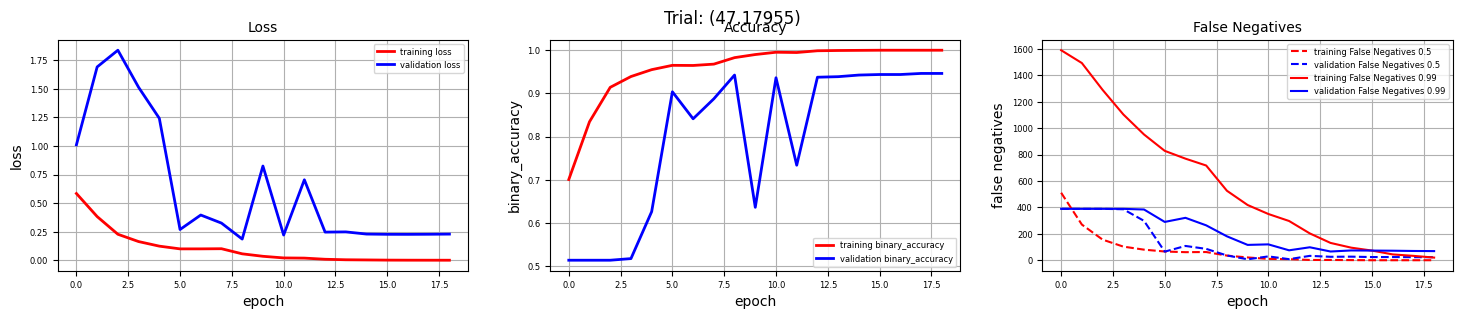

In [9]:
# CNN Training
def train_malaria_model(model, X_train_input, y_train_input, description, verbose=1):
    # Stop training when no further improvement is seen in the metric
    early_stop = EarlyStopping(
        monitor="val_loss",    # metric to monitor
        patience=10,           # stop when no improvement after 10 consecutive epochs
        mode="min",            # stop when metric stops decreasing
        restore_best_weights=True,
        verbose=verbose,             # display the actions taken
    )
    # Callback to save the Keras model or model weights at some frequency
    checkpoint = ModelCheckpoint(
        filepath="malaria.keras",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_freq="epoch",
        verbose=verbose,             # display the actions taken
    )
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr_on_plateau = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        mode="min",
        # min_delta=0.0001,
        # cooldown=0,
        min_lr=1e-6,
        verbose=verbose,             # display the actions taken
    )
    # Save output to be used with tensorboard
    tensorboard = TensorBoard(
        log_dir=f"logs/malaria_{description}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )

    # Train the model
    start_timing = time.time()
    history = model.fit(
        x=X_train_input,
        y=y_train_input,
        batch_size=32,
        epochs=50,
        validation_split=0.2,
        verbose=verbose,             # display the actions taken
        callbacks=[early_stop, reduce_lr_on_plateau, tensorboard],
    )
    end_timing = time.time()
    return history, end_timing - start_timing

history, training_time = train_malaria_model(model=malaria_model, X_train_input=X_train, y_train_input=y_train, description="example")
display_value("Training time", training_time) 
plot_history(history, training_time, "Trial")    

In [10]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC 
# method I: plt
def plot_roc_curve(model, X_test_input, y_test_input):

    y_pred_proba = model.predict(X_test_input).flatten()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_input, y_pred_proba, pos_label=1)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    display_value("AUC", area_under_curve)

    # ROC
    fig, ax = plt.subplots(figsize = (6, 3), sharey=False)
    ax.set_title("Receiver Operating Characteristic: Infected TRUE")
    ax.plot(false_positive_rate, true_positive_rate, color="blue", label = f"AUC = {area_under_curve}")
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid()
    ax.legend(loc='upper right')
    plt.show()

def print_binary_metrics(model, X_test_input, y_test_input, decision_boundary=0.5, title="Binary Results"):
    display_title(f"{title} - Treshold({decision_boundary})")
    y_pred_proba = model.predict(X_test_input).flatten()
    y_pred_class = (y_pred_proba >= decision_boundary).astype(int)

    display_title("Scikit learn metrics")
    display_title("classification report", classification_report(y_test_input, y_pred_class))
    display_title("confusion matrix",confusion_matrix(y_test_input, y_pred_class, labels=[0, 1]))
    display("    p0 p1")
    display("a0: TN FP")
    display("a1: FN TP")
    display_value("Accuracy score", (accuracy_score(y_test_input, y_pred_class) * 100))
    display("")
    display_title("Tensorflow evaluate")
    metrics = model.evaluate(X_test_input, y_test_input, return_dict=True)
    for m,v in metrics.items():
        display_value(m, v)
    display("-----------------------------------------")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC: 0.994781


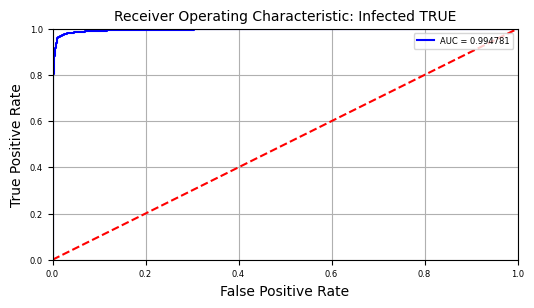

Training Set - Treshold(0.5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2000
           1       0.99      0.95      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

confusion matrix
[[1979   21]
 [  97 1903]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 97.05


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9745 - false_negatives_50pct: 40.2063 - false_negatives_99pct: 403.0159 - false_positives_50pct: 8.0159 - false_positives_99pct: 0.0635 - loss: 0.0815 - precision: 0.9916 - true_negatives_50pct: 1015.8492 - true_negatives_99pct: 1023.8016 - true_positives_50pct: 967.6746 - true_positives_99pct: 604.8651  
binary_accuracy: 0.9704999923706055
false_negatives_50pct: 97.0
false_negatives_99pct: 828.0
false_positives_50pct: 21.0
false_positives_99pct: 2.0
loss: 0.09065578132867813
precision: 0.9890852570533752
true_negatives_50pct: 1979.0
true_negatives_99pct: 1998.0
true_positives_50pct: 1903.0
true_positives_99pct: 1172.0


'-----------------------------------------'

Test Set - Treshold(0.5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2000
           1       0.95      0.90      0.92      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000

confusion matrix
[[1911   89]
 [ 208 1792]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 92.575


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9282 - false_negatives_50pct: 103.0238 - false_negatives_99pct: 457.3413 - false_positives_50pct: 45.5635 - false_positives_99pct: 2.0714 - loss: 0.2307 - precision: 0.9506 - true_negatives_50pct: 979.9207 - true_negatives_99pct: 1023.4127 - true_positives_50pct: 903.2381 - true_positives_99pct: 548.9207
binary_accuracy: 0.9257500171661377
false_negatives_50pct: 208.0
false_negatives_99pct: 904.0
false_positives_50pct: 89.0
false_positives_99pct: 6.0
loss: 0.23972313106060028
precision: 0.952684760093689
true_negatives_50pct: 1911.0
true_negatives_99pct: 1994.0
true_positives_50pct: 1792.0
true_positives_99pct: 1096.0


'-----------------------------------------'

'----------------------------------------------------------------------------------'

Training Set - Treshold(0.99)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2000
           1       1.00      0.59      0.74      2000

    accuracy                           0.79      4000
   macro avg       0.85      0.79      0.78      4000
weighted avg       0.85      0.79      0.78      4000

confusion matrix
[[1998    2]
 [ 828 1172]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 79.25


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9745 - false_negatives_50pct: 40.2063 - false_negatives_99pct: 403.0159 - false_positives_50pct: 8.0159 - false_positives_99pct: 0.0635 - loss: 0.0815 - precision: 0.9916 - true_negatives_50pct: 1015.8492 - true_negatives_99pct: 1023.8016 - true_positives_50pct: 967.6746 - true_positives_99pct: 604.8651  
binary_accuracy: 0.9704999923706055
false_negatives_50pct: 97.0
false_negatives_99pct: 828.0
false_positives_50pct: 21.0
false_positives_99pct: 2.0
loss: 0.09065578132867813
precision: 0.9890852570533752
true_negatives_50pct: 1979.0
true_negatives_99pct: 1998.0
true_positives_50pct: 1903.0
true_positives_99pct: 1172.0


'-----------------------------------------'

Test Set - Treshold(0.99)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.69      1.00      0.81      2000
           1       0.99      0.55      0.71      2000

    accuracy                           0.77      4000
   macro avg       0.84      0.77      0.76      4000
weighted avg       0.84      0.77      0.76      4000

confusion matrix
[[1994    6]
 [ 904 1096]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 77.25


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9282 - false_negatives_50pct: 103.0238 - false_negatives_99pct: 457.3413 - false_positives_50pct: 45.5635 - false_positives_99pct: 2.0714 - loss: 0.2307 - precision: 0.9506 - true_negatives_50pct: 979.9207 - true_negatives_99pct: 1023.4127 - true_positives_50pct: 903.2381 - true_positives_99pct: 548.9207
binary_accuracy: 0.9257500171661377
false_negatives_50pct: 208.0
false_negatives_99pct: 904.0
false_positives_50pct: 89.0
false_positives_99pct: 6.0
loss: 0.23972313106060028
precision: 0.952684760093689
true_negatives_50pct: 1911.0
true_negatives_99pct: 1994.0
true_positives_50pct: 1792.0
true_positives_99pct: 1096.0


'-----------------------------------------'

'=================================================================================='

In [11]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC

# Hier zijn enkele vergelijkingen gemaakt met de metrics in sklearn en tensorflow(keras)
# Plot ROC
plot_roc_curve(model=malaria_model, X_test_input=X_train, y_test_input=y_train)

# Metrics on the training set
print_binary_metrics(model=malaria_model, X_test_input=X_train, y_test_input=y_train, decision_boundary=0.5, title="Training Set")
# Metrics on the test set
print_binary_metrics(model=malaria_model, X_test_input=X_test, y_test_input=y_test, decision_boundary=0.5, title="Test Set")
display("----------------------------------------------------------------------------------")

# Metrics on the training set
print_binary_metrics(model=malaria_model, X_test_input=X_train, y_test_input=y_train, decision_boundary=0.99, title="Training Set")
# Metrics on the test set
print_binary_metrics(model=malaria_model, X_test_input=X_test, y_test_input=y_test, decision_boundary=0.99, title="Test Set")
display("==================================================================================")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.0005312  0.00833841 0.00341086 ... 0.27010798 0.0007563  0.00038852]
[0 1]
[2898 1102]
[0 0 0 ... 0 0 0]
6
904
Test DataSet

Examples of False Positives (not-infected, but predicted as infected)


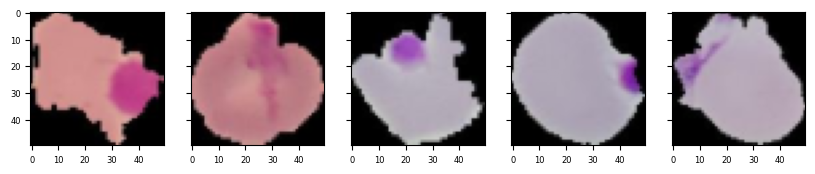

Examples of False Negatives (infected, but predicted as not-infected)


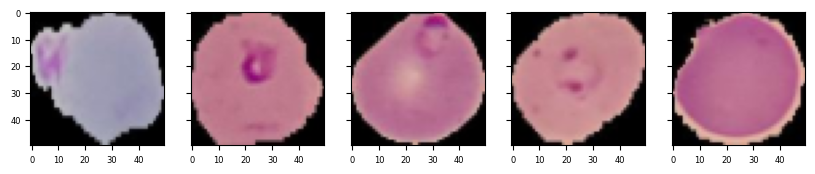

In [12]:
# Visualiseer enkele verkeerd geclassificeerde afbeeldingen van de ene klasse en van de andere klasse. 
y_pred_proba_test = malaria_model.predict(X_test).flatten()
print(y_pred_proba_test)
y_pred_class_test = (y_pred_proba_test >= 0.99).astype(int)
a, b = np.unique(y_pred_class_test, return_counts=True)
print(a)
print(b)
print(y_pred_class_test)

X_test_fp = X_test[(y_test == 0) & (y_pred_class_test == 1)]
X_test_fn = X_test[(y_test == 1) & (y_pred_class_test == 0)]
print(len(X_test_fp))
print(len(X_test_fn))

display_title("Test DataSet\n")
display_title("Examples of False Positives (not-infected, but predicted as infected)")
_, axes_fp_test = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_test_fp)])):
    axes_fp_test[i].imshow(X_test_fp[i])
plt.show()

display_title("Examples of False Negatives (infected, but predicted as not-infected)")
_, axes_fn_test = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_test_fn)])):
    axes_fn_test[i].imshow(X_test_fn[i])
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[0.99194384 0.00761472 0.998111   ... 0.00177826 0.9920008  0.99655044]
[0 1]
[2826 1174]
[1 0 1 ... 0 1 1]
2
828
Test DataSet

Examples of False Positives (not-infected, but predicted as infected)


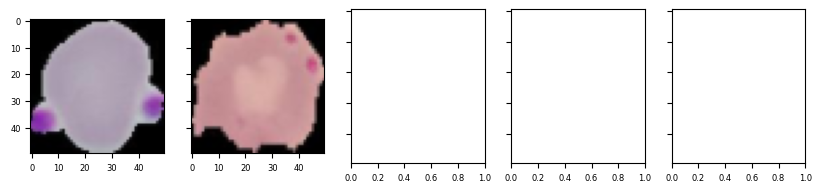

Examples of False Negatives (infected, but predicted as not-infected)


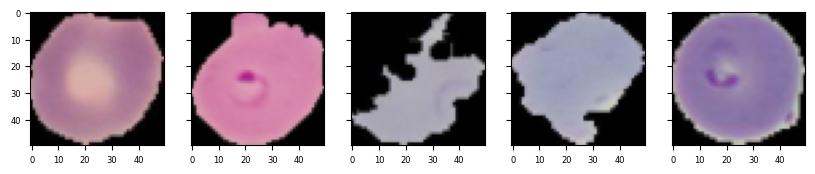

In [13]:
# Visualiseer enkele verkeerd geclassificeerde afbeeldingen van de ene klasse en van de andere klasse. 
y_pred_proba_train = malaria_model.predict(X_train).flatten()
print(y_pred_proba_train)
y_pred_class_train = (y_pred_proba_train >= 0.99).astype(int)
a, b = np.unique(y_pred_class_train, return_counts=True)
print(a)
print(b)
print(y_pred_class_train)

X_train_fp = X_train[(y_train == 0) & (y_pred_class_train == 1)]
X_train_fn = X_train[(y_train == 1) & (y_pred_class_train == 0)]
print(len(X_train_fp))
print(len(X_train_fn))

display_title("Test DataSet\n")
display_title("Examples of False Positives (not-infected, but predicted as infected)")
_, axes_fp_train = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_train_fp)])):
    axes_fp_train[i].imshow(X_train_fp[i])
plt.show()

display_title("Examples of False Negatives (infected, but predicted as not-infected)")
_, axes_fn_train = plt.subplots(1, 5, figsize = (10, 2), sharey=True)
for i in range(min([5, len(X_train_fn)])):
    axes_fn_train[i].imshow(X_train_fn[i])
plt.show()


---

### Zoektocht naar een beter model

In [14]:
# Optimalisatie van het netwerk

# Verzamel de verschillende metrieken
def collect_accuracy(model, X_train_input, y_train_input, X_test_input, y_test_input, decision_boundary=0.5, verbose=1):
    # Train accuracy
    y_train_pred_proba = model.predict(X_train_input, verbose=verbose).flatten()
    y_train_pred_class = (y_train_pred_proba >= decision_boundary).astype(int)
    train_accuracy = accuracy_score(y_train_input, y_train_pred_class) * 100

    # Test accuracy
    y_test_pred_proba = model.predict(X_test_input, verbose=verbose).flatten()
    y_test_pred_class = (y_test_pred_proba >= decision_boundary).astype(int)
    test_accuracy = accuracy_score(y_test_input, y_test_pred_class) * 100

    display_value(f"Accuracy - ({model.howest}) - Threshold({decision_boundary:.2f})", f"Train({train_accuracy:.2f})\tTest({test_accuracy:.2f})")
    return getattr(model, "howest", "xx"), decision_boundary, train_accuracy, test_accuracy

In [15]:

# Routine om een CNN te bouwen uit een kortere omschrijving
def model_explorer(name, input_shape, feature_extractor, classifier, skip=False):
    if skip:
        return None
        
    # Create a model from a simplified description
    model = Sequential()
    # Input Layer
    model.add(Input(shape=input_shape))
    
    # Feature Extraction Layers
    for fl in feature_extractor:
        match fl:
            case ("C", filters):
                model.add(Conv2D(filters=filters, kernel_size=(3, 3)))
            case ("A", "relu"):
                model.add(Activation(tf.keras.activations.relu))
            case ("A", "leaky_relu"):
                model.add(Activation(tf.keras.activations.leaky_relu))
            case "B":
                model.add(BatchNormalization())
            case ("Dr", rate):
                model.add(Dropout(rate=rate))
            case ("P", "max"):
                model.add(MaxPooling2D(pool_size=(2, 2)))
            case ("P", "avg"):
                model.add(AveragePooling2D(pool_size=(2, 2)))
            case x:
                print(f"Unknown layer type {x}")

    # Prepare for classification
    # Flatten the output of the feature extraction layers
    model.add(Flatten())

    # Classification Layers 
    for cl in classifier:
        match cl:
            case ("D", units):
                model.add(Dense(units=units))
            case ("D", units, kernel_regulizer):
                model.add(Dense(units=units, kernel_regularizer=L2(0.01)))
            case ("A", activation):
                model.add(Activation(activation))
            case "B":
                model.add(BatchNormalization())
            case ("Dr", rate):
                model.add(Dropout(rate=rate))
            case x:
                print(f"Unknown layer type {x}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        # metrics=['accuracy'],
        metrics=[
            # tf.keras.metrics.Accuracy(),
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.TrueNegatives(thresholds=0.5, name="true_negatives_50pct"),
            tf.keras.metrics.TruePositives(thresholds=0.5, name="true_positives_50pct"),
            tf.keras.metrics.FalseNegatives(thresholds=0.5, name="false_negatives_50pct"),
            tf.keras.metrics.FalsePositives(thresholds=0.5, name="false_positives_50pct"),
            tf.keras.metrics.TrueNegatives(thresholds=0.99, name="true_negatives_99pct"),
            tf.keras.metrics.TruePositives(thresholds=0.99, name="true_positives_99pct"),
            tf.keras.metrics.FalseNegatives(thresholds=0.99, name="false_negatives_99pct"),
            tf.keras.metrics.FalsePositives(thresholds=0.99, name="false_positives_99pct"),
        ],
    )
    setattr(model, "howest", name)

    return model



In [16]:
# Some models to see what the effects are
image_shape = (image_size, image_size, 3)

malaria_models = [
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 01",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), ("A", "relu"), "B", 
            ("D", 64), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 02",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 03",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "avg"),
            ("C", 64), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "avg"),
            ("C", 32), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "avg"),
        ],
        classifier=[
            ("D", 128), ("A", "relu"), "B", 
            ("D", 64), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 04",
        input_shape=(image_size, image_size, 3),
        feature_extractor=[
            ("C", 128), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 32), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), ("A", "relu"), "B", 
            ("D", 64), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 05",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 32), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), ("A", "relu"), "B", 
            ("D", 64), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 06",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 256), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 128), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
            ("C", 32), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("P", "max"),
        ],
        classifier=[
            ("D", 128), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 64), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 07",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 08",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 09",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 10",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 11",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 12",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 13",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 14",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 16), ("A", "relu"), "B", 
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 64), ("A", "relu"), "B", 
            ("C", 64), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 64), ("A", "relu"), "B", 
            ("D", 32), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 15",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 8), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 16), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 1024), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 16",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 8), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 16), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 32), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 1024), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 17",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 8), "B", ("A", "leaky_relu"),
            ("P", "max"),
            ("C", 16), "B", ("A", "leaky_relu"),
            ("P", "max"),
            ("C", 32), "B", ("A", "leaky_relu"),
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 1024), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 18",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 128), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 256), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 128), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 128), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
    model_explorer(
        name=f"Exploration ({image_size}x{image_size}) 19",
        input_shape=image_shape,
        feature_extractor=[
            ("C", 128), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 256), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 256), ("A", "relu"), "B", 
            ("P", "max"),
            ("C", 128), ("A", "relu"), "B", 
            ("P", "max"),
        ],
        classifier=[
            ("D", 1024, True), ("A", "relu"), "B", 
            ("Dr", 0.3),
            ("D", 512, True), ("A", "relu"), "B", 
            ("D", 64, True), ("A", "relu"), "B", 
            ("D", 1),
            ("A", "sigmoid"),
        ]
    ),
]


Session: 0-Exploration (50x50) 01
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_1', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_1', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 'val_true_positives_50pct', 'val_true_positives_99pct', 'learning_rate'])


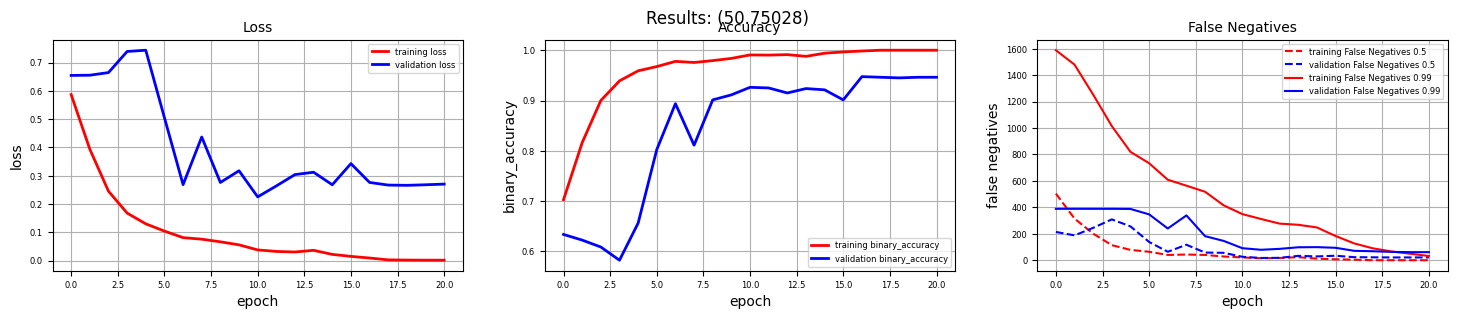

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 01) - Threshold(0.50): Train(97.45)	Test(92.58)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 01) - Threshold(0.90): Train(96.12)	Test(91.65)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 01) - Threshold(0.99): Train(89.35)	Test(86.30)
Session: 1-Exploration (50x50) 02
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_2', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_2', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 

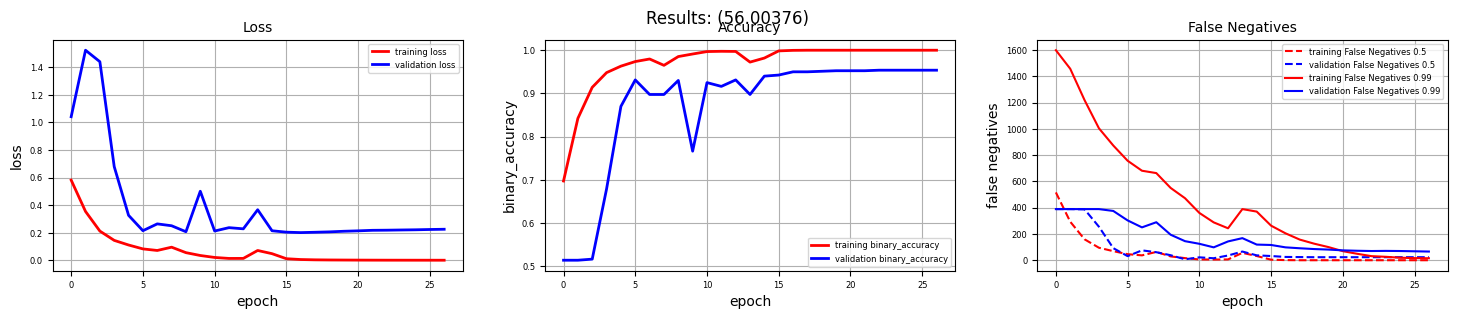

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 02) - Threshold(0.50): Train(98.38)	Test(93.88)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 02) - Threshold(0.90): Train(96.92)	Test(92.17)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 02) - Threshold(0.99): Train(90.97)	Test(87.40)
Session: 2-Exploration (50x50) 03


E0000 00:00:1744841030.342023 3373631 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_3', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_3', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 'val_true_positives_50pct', 'val_true_positives_99pct', 'learning_rate'])


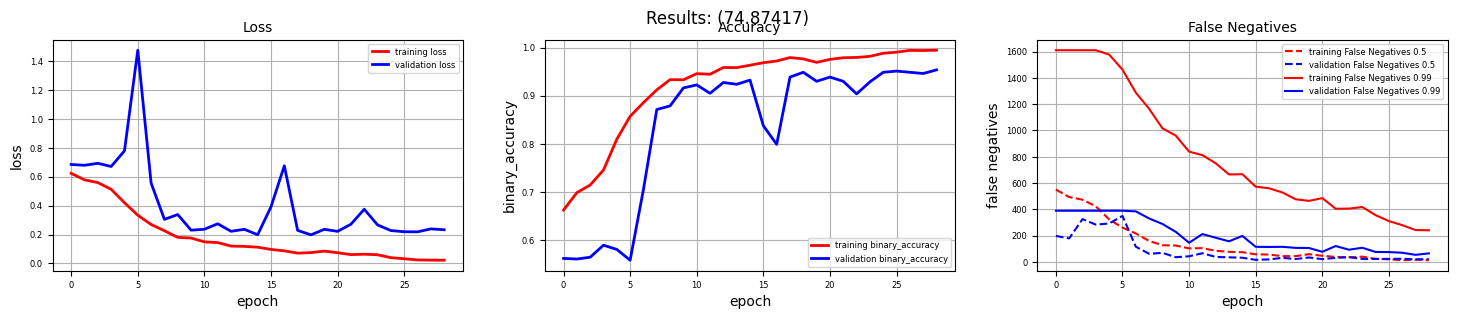

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 03) - Threshold(0.50): Train(96.80)	Test(93.58)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy - (Exploration (50x50) 03) - Threshold(0.90): Train(94.85)	Test(92.27)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 03) - Threshold(0.99): Train(85.80)	Test(84.00)
Session: 3-Exploration (50x50) 04


E0000 00:00:1744841109.253595 3373631 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_4', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_4', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 'val_true_positives_50pct', 'val_true_positives_99pct', 'learning_rate'])


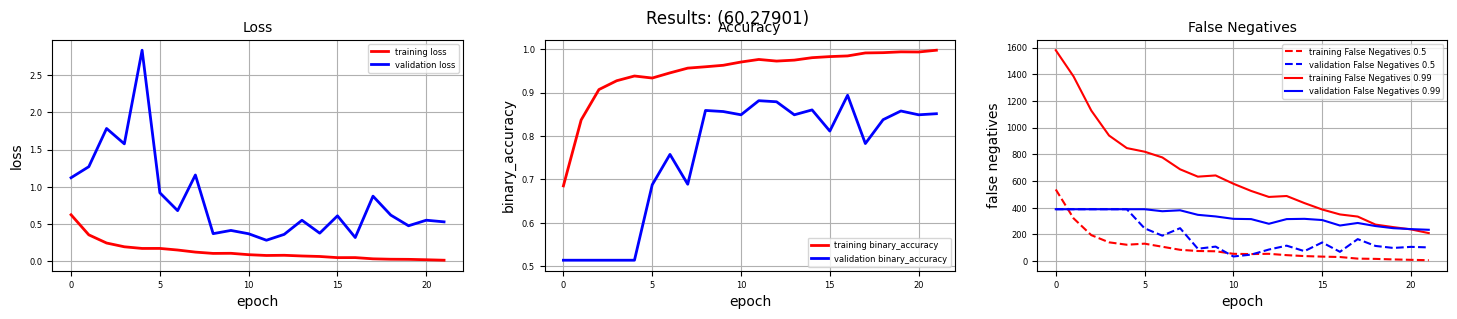

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy - (Exploration (50x50) 04) - Threshold(0.50): Train(92.10)	Test(89.70)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 04) - Threshold(0.90): Train(80.30)	Test(78.30)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 04) - Threshold(0.99): Train(59.40)	Test(58.07)
Session: 4-Exploration (50x50) 05


E0000 00:00:1744841174.488207 3373631 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_5', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_5', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 'val_true_positives_50pct', 'val_true_positives_99pct', 'learning_rate'])


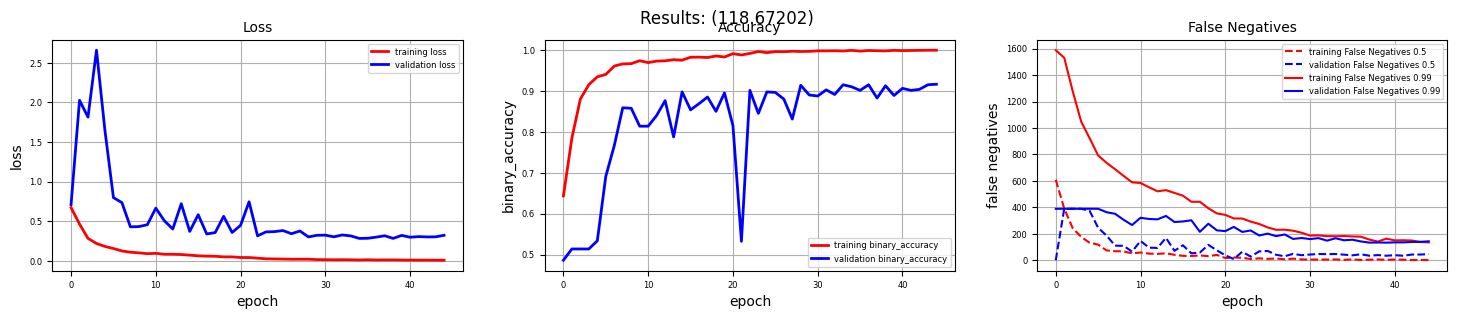

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 05) - Threshold(0.50): Train(95.00)	Test(91.97)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 05) - Threshold(0.90): Train(91.92)	Test(88.72)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 05) - Threshold(0.99): Train(80.85)	Test(78.97)
Session: 5-Exploration (50x50) 06


E0000 00:00:1744841297.237329 3373631 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_6', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_6', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 'val_true_positives_50pct', 'val_true_positives_99pct', 'learning_rate'])


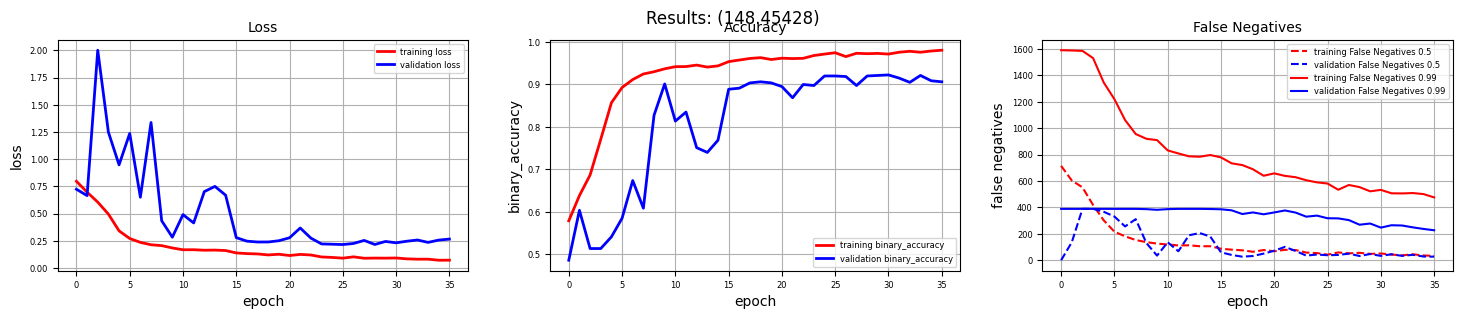

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy - (Exploration (50x50) 06) - Threshold(0.50): Train(93.85)	Test(91.88)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy - (Exploration (50x50) 06) - Threshold(0.90): Train(87.60)	Test(86.58)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy - (Exploration (50x50) 06) - Threshold(0.99): Train(60.42)	Test(59.27)
Session: 6-Exploration (50x50) 07
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_7', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_7', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 

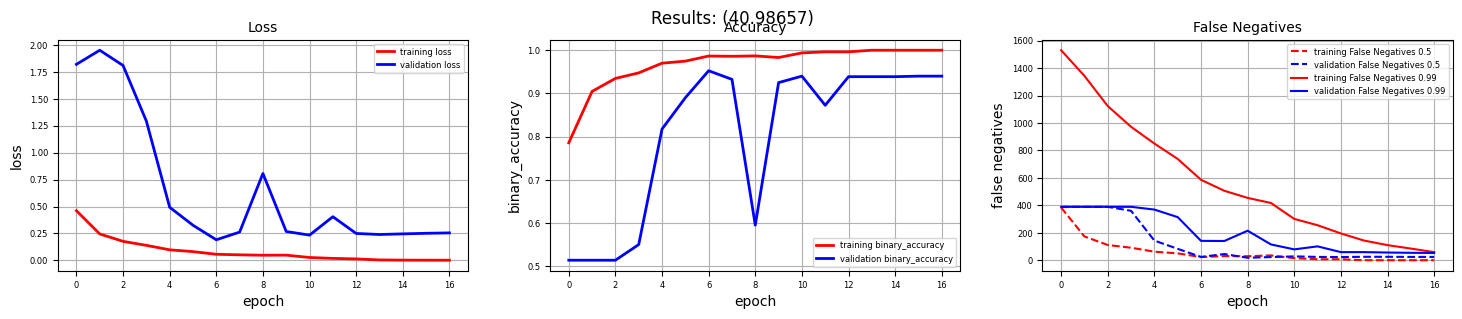

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 07) - Threshold(0.50): Train(96.78)	Test(94.23)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 07) - Threshold(0.90): Train(93.90)	Test(91.00)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 07) - Threshold(0.99): Train(82.90)	Test(81.50)
Session: 7-Exploration (50x50) 08
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_8', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_8', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 

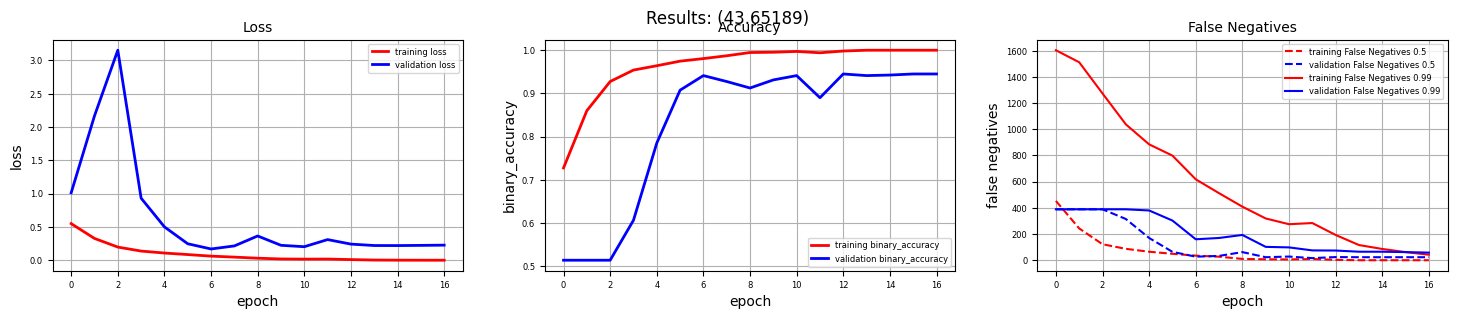

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 08) - Threshold(0.50): Train(96.75)	Test(93.25)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 08) - Threshold(0.90): Train(93.33)	Test(90.60)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 08) - Threshold(0.99): Train(79.47)	Test(78.53)
Session: 8-Exploration (50x50) 09
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_9', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_9', 'val_true_negatives_50pct', 'val_true_negatives_99pct', 

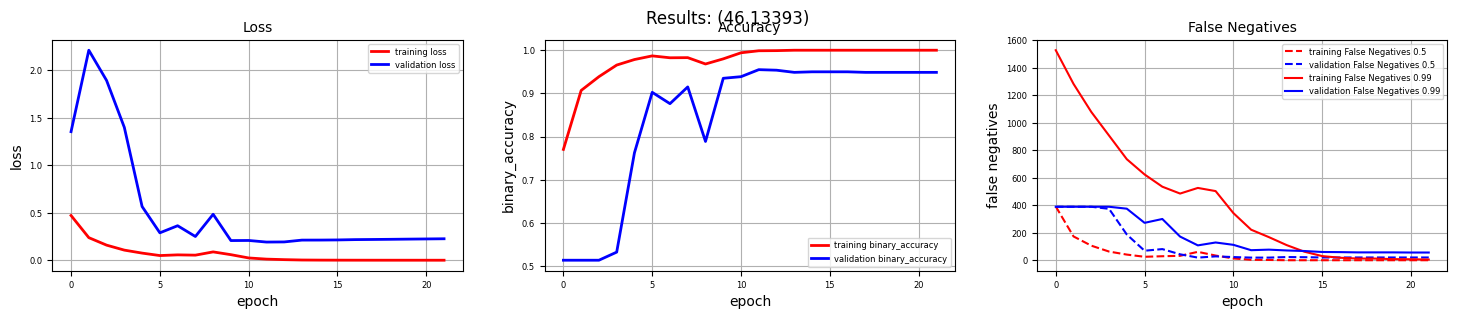

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 09) - Threshold(0.50): Train(98.62)	Test(93.92)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 09) - Threshold(0.90): Train(97.58)	Test(93.38)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 09) - Threshold(0.99): Train(93.42)	Test(89.33)
Session: 9-Exploration (50x50) 10
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_10', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_10', 'val_true_negatives_50pct', 'val_true_negatives_99pct'

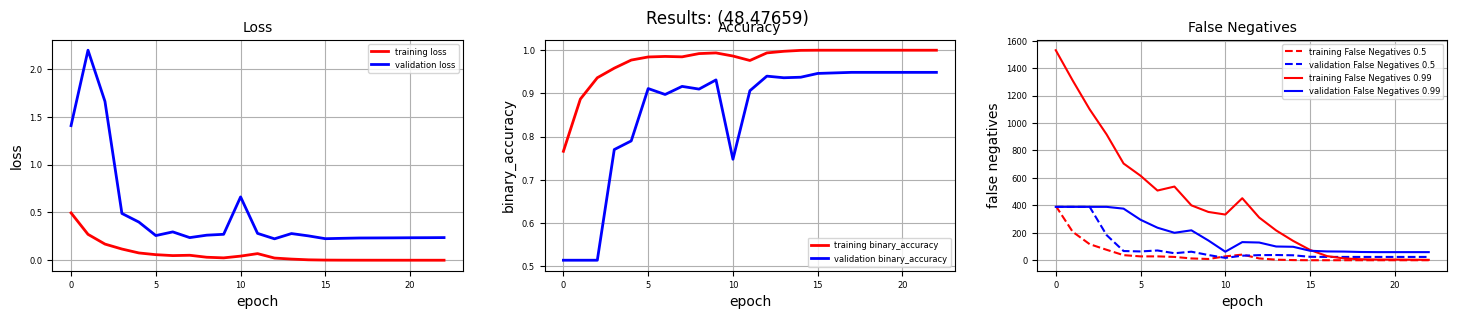

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 10) - Threshold(0.50): Train(97.22)	Test(92.67)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 10) - Threshold(0.90): Train(93.95)	Test(90.00)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 10) - Threshold(0.99): Train(87.10)	Test(83.38)
Session: 10-Exploration (50x50) 11
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_11', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_11', 'val_true_negatives_50pct', 'val_true_negatives_99pct

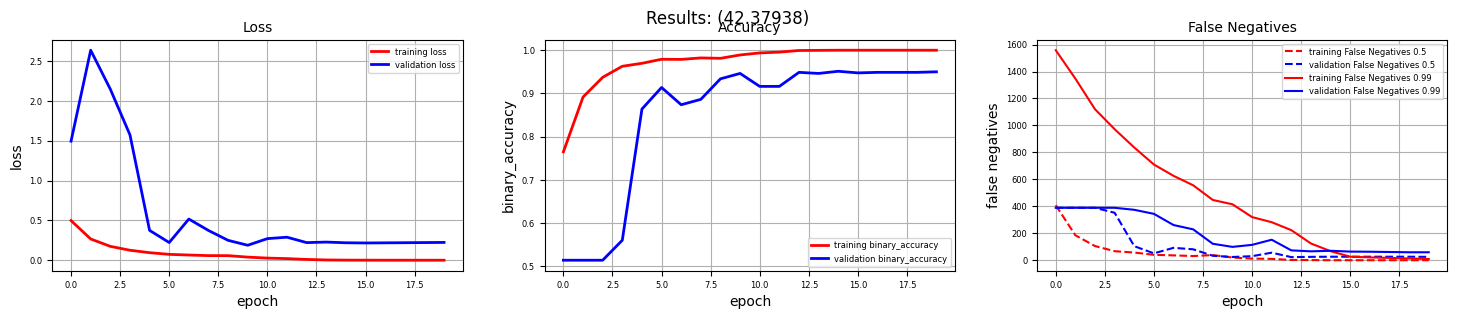

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 11) - Threshold(0.50): Train(97.50)	Test(93.17)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 11) - Threshold(0.90): Train(95.28)	Test(91.90)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 11) - Threshold(0.99): Train(88.80)	Test(86.08)
Session: 11-Exploration (50x50) 12
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_12', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_12', 'val_true_negatives_50pct', 'val_true_negatives_99pct

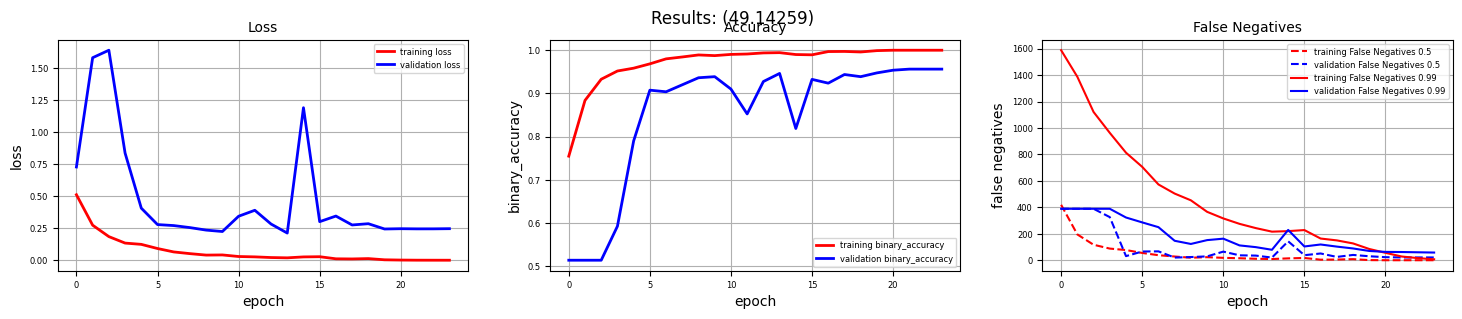

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 12) - Threshold(0.50): Train(97.80)	Test(93.15)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 12) - Threshold(0.90): Train(96.80)	Test(92.70)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 12) - Threshold(0.99): Train(93.03)	Test(89.48)
Session: 12-Exploration (50x50) 13
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_13', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_13', 'val_true_negatives_50pct', 'val_true_negatives_99pct

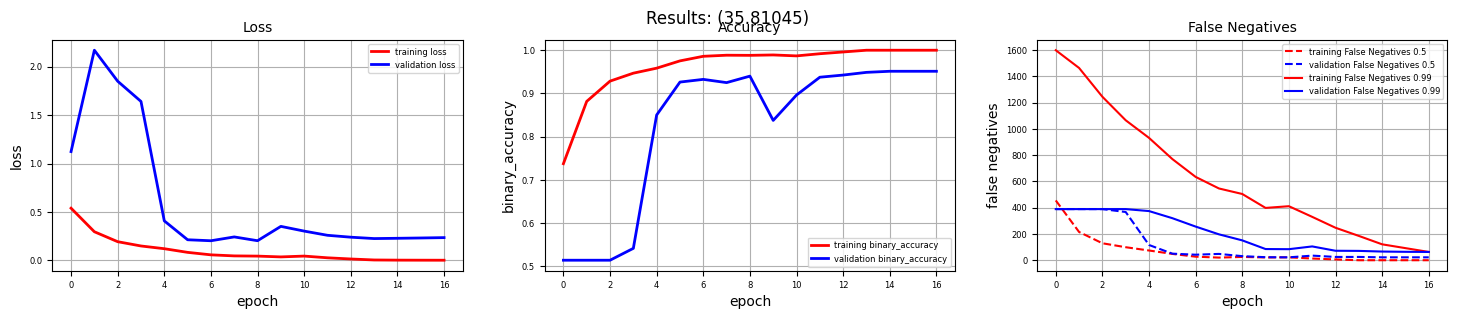

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 13) - Threshold(0.50): Train(96.03)	Test(92.65)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 13) - Threshold(0.90): Train(90.28)	Test(87.48)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 13) - Threshold(0.99): Train(68.85)	Test(69.23)
Session: 13-Exploration (50x50) 14
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_14', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_14', 'val_true_negatives_50pct', 'val_true_negatives_99pct

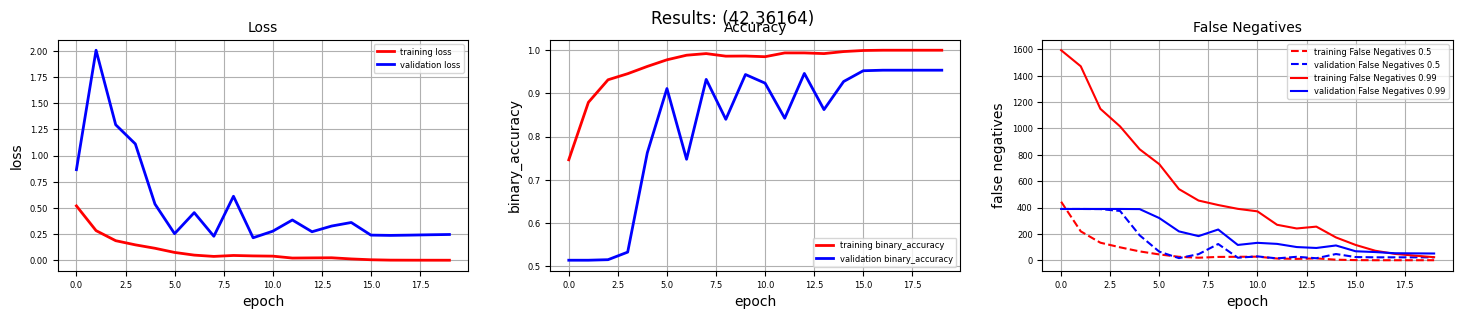

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 14) - Threshold(0.50): Train(97.10)	Test(93.03)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 14) - Threshold(0.90): Train(95.23)	Test(91.10)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy - (Exploration (50x50) 14) - Threshold(0.99): Train(86.33)	Test(83.50)
Session: 14-Exploration (50x50) 15
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_15', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_15', 'val_true_negatives_50pct', 'val_true_negatives_99pct

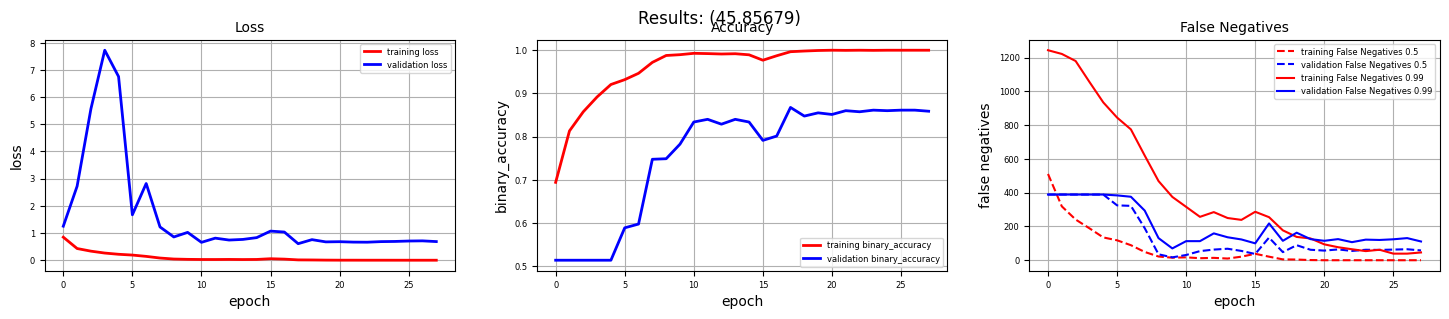

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 15) - Threshold(0.50): Train(96.83)	Test(85.12)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 15) - Threshold(0.90): Train(96.50)	Test(85.55)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 15) - Threshold(0.99): Train(93.47)	Test(82.65)
Session: 15-Exploration (50x50) 16
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_16', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_16', 'val_true_negatives_50pct', 'val_true_negatives_99pct

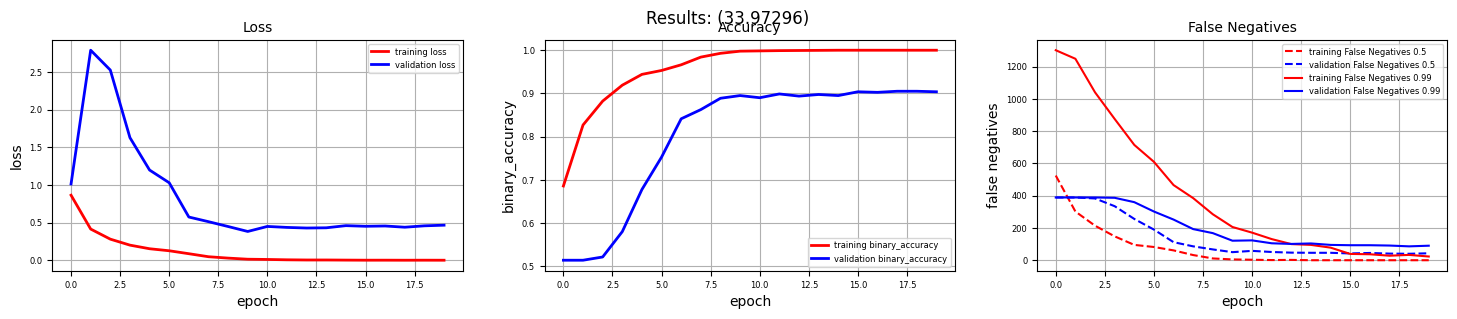

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 16) - Threshold(0.50): Train(97.40)	Test(88.95)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 16) - Threshold(0.90): Train(95.43)	Test(86.42)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 16) - Threshold(0.99): Train(88.78)	Test(82.30)
Session: 16-Exploration (50x50) 17
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_17', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_17', 'val_true_negatives_50pct', 'val_true_negatives_99pct

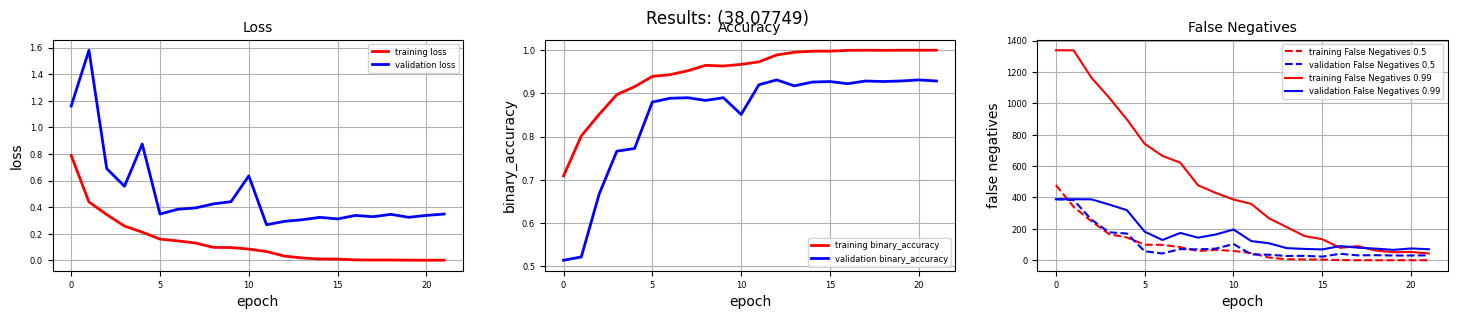

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 17) - Threshold(0.50): Train(97.02)	Test(91.12)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 17) - Threshold(0.90): Train(94.97)	Test(89.35)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy - (Exploration (50x50) 17) - Threshold(0.99): Train(87.60)	Test(83.73)
Session: 17-Exploration (50x50) 18
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_18', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_18', 'val_true_negatives_50pct', 'val_true_negatives_99pct

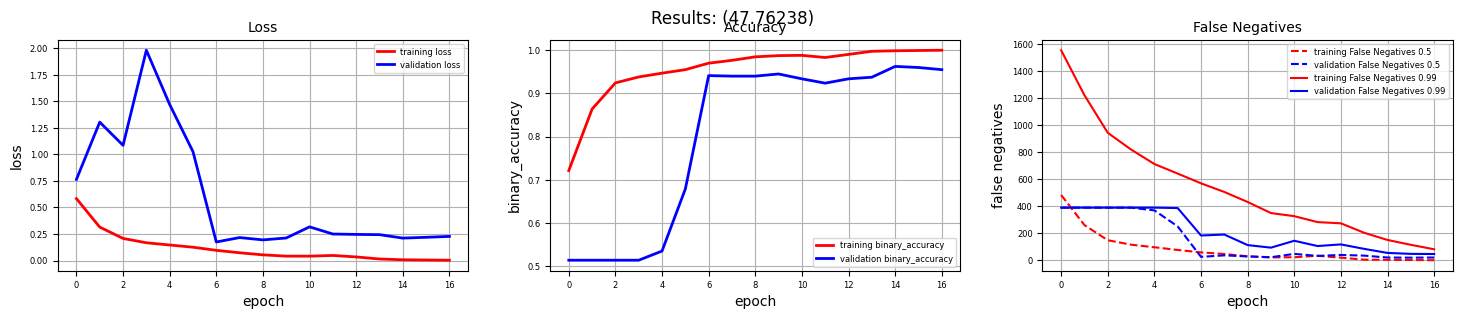

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy - (Exploration (50x50) 18) - Threshold(0.50): Train(96.15)	Test(92.85)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy - (Exploration (50x50) 18) - Threshold(0.90): Train(93.12)	Test(90.62)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy - (Exploration (50x50) 18) - Threshold(0.99): Train(77.20)	Test(75.95)
Session: 18-Exploration (50x50) 19
---> dict_keys(['binary_accuracy', 'false_negatives_50pct', 'false_negatives_99pct', 'false_positives_50pct', 'false_positives_99pct', 'loss', 'precision_19', 'true_negatives_50pct', 'true_negatives_99pct', 'true_positives_50pct', 'true_positives_99pct', 'val_binary_accuracy', 'val_false_negatives_50pct', 'val_false_negatives_99pct', 'val_false_positives_50pct', 'val_false_positives_99pct', 'val_loss', 'val_precision_19', 'val_true_negatives_50pct', 'val_true_negatives_99pct

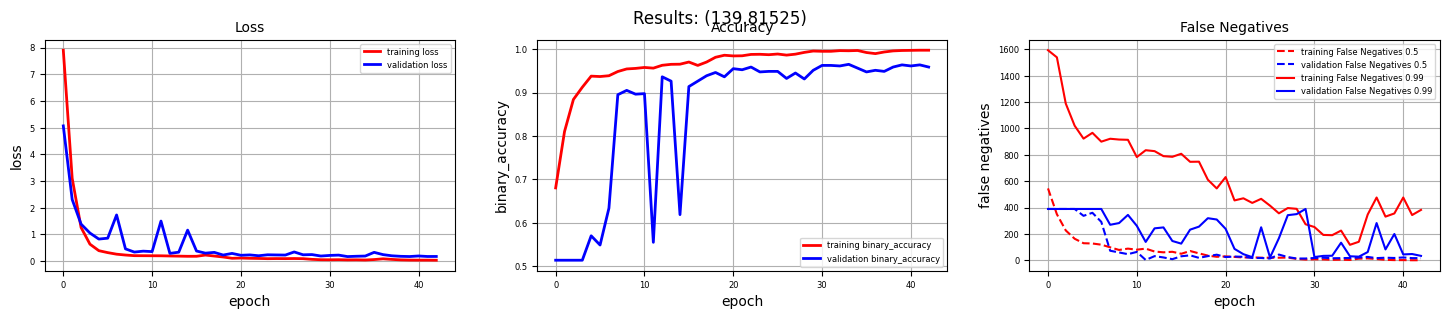

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy - (Exploration (50x50) 19) - Threshold(0.50): Train(98.65)	Test(94.00)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy - (Exploration (50x50) 19) - Threshold(0.90): Train(98.30)	Test(94.10)
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy - (Exploration (50x50) 19) - Threshold(0.99): Train(97.00)	Test(93.47)
Exploration (50x50) 01	threshold:	0.50	Train:	97.45	Test:	92.58)
Exploration (50x50) 01	threshold:	0.90	Train:	96.12	Test:	91.65)
Exploration (50x50) 01	threshold:	0.99	Train:	89.35	Test:	86.30)
Exploration (50x50) 02	threshold:	0.50	Train:	98.38	Test:	93.88)
Exploration (50x50) 02	threshold:	0.90	Train:	96.92	Test:	92.17)
Exploration (50x50) 02	threshold:	0.99	Train:	90.97	Test:	87.40)
Exploration (50x50) 03	threshold:	0.50	Train:	96.80	Test:	93.58)
Exploration (50x50) 03	threshold:	0.90	Train:	94.85	Test:	9

In [17]:
# Perform the search
collected_results = []
for i, m in enumerate(malaria_models):
    if m is None:
        continue

    print(f"Session: {i}-{getattr(m, 'howest', 'xx')}")
    # een kopy nemen van de originele data om mee te werken
    # de resultaten zijn voor hetzelfde net verschillend, waarom??
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    y_train_copy = y_train.copy()
    y_test_copy = y_test.copy()
    training_history, training_time = train_malaria_model(
        model=m,
        X_train_input=X_train_copy, y_train_input=y_train_copy,
        description=f"{i}-{getattr(m, 'howest', 'xx')}",
        verbose=0,
    )
    plot_history(training_history, training_time)  
    for threshold in [0.5, 0.9, 0.99]:
        collected_results.append(
            collect_accuracy(
                model=m,
                X_train_input=X_train_copy, y_train_input=y_train_copy,
                X_test_input=X_test_copy, y_test_input=y_test_copy,
                decision_boundary=threshold,
                verbose=1,
            )
        )

# Summary
for n, t, train_a, test_a in collected_results:
    print(f"{n}\tthreshold:\t{t:.2f}\tTrain:\t{train_a:.2f}\tTest:\t{test_a:.2f})")



**Schrijf hier jouw conclusies:**



### Conclusies malaria experiment

#### Gevoeligheid

Het eerste wat opvalt is dat de resultaten zeer uiteenlopend zijn.
Er is geen direct verband te zien met de gekozen archtitectuur en de verwachte resultaten.
Er is dus een zoektocht nodig met een dosis trial/error.

Het gebruik van sigmoid als activation function geeft de mogelijkheid om het aantal False Negatives van het uiteindelijke model te verkleinen.

Het verplaatsten van de BatchNormalisation voor en achter de Activation gaf een duidelijke verandering in gedrag van het CNN.


#### Opbouw netwerk

##### Preprocessing
De "layers: in tensorflow/keras maken het mogelijk om deze snel nieuwe architecturen op te zetten en te testen.

Een belangrijk aspect hierbij is de mogelijkheid om "preprocessing layers" toe te voegen.
```
    # Create a Sequential model
    model = models.Sequential()
    
    # Add preprocessing layers
    model.add(layers.Reshape(1./255))  # Normalize pixel values to [0, 1]
    model.add(layers.Rescaling(1./255))  # Normalize pixel values to [0, 1]
    model.add(layers.RandomFlip("horizontal"))  # Randomly flip images horizontally
    model.add(layers.RandomRotation(0.2))  # Randomly rotate images
```
Hierdoor kan het uiteindelijke CNN gebruikt worden met willekeurige images die in de juiste vorm worden gegoten en kan dus end-to-end gebruikt worden.

##### Regulizers
Naast de kernel_regularization kan er ook een activity_regularization toegepast worden.
Ik heb me beperkt to kernel_regularization (voorlopig) omdat er BatchNormalisation wordt toegepast (op de output).
De kernel_regularization reflecteert ook in de weights van het CNN.

#### Metrics

Naast de accuracy is er de mogelijkheid om meerdere metrieken te volgen tijdens het training process.
Dit geeft een beter zicht op het gedrag van verschillende aspecten van het model, dat gebruikt kan worden om de 

#### Opmerking

Bij elke run zijn de resultaten verschillend. Ik vermoed dat ook hier afrondingsfouten (32bit GPU) and hardware gerelateerde elementen de oorzaak zijn. 

---

### Transfer learning
Hertrain het VGG19 netwerk (of optioneel ResNet) op de malaria dataset. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.

In [18]:
image_shape = (image_size, image_size, 3)
image_shape

(50, 50, 3)

In [19]:
# transfer learning

# Laad het VGG19 model zonder de classificatie, voor de gekozen shape van de images
feature_exctractor = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=image_shape)

# Zet de gewichten van feature extraction layers vast, zodat ze niet aangepast worden bij verder training.
feature_exctractor.trainable = False

# Converteer naar een sequential model.
# Nieuw sequential model met als basis de vg19 extractor
malaria_model_vgg19 = Sequential()
malaria_model_vgg19.add(feature_exctractor)

# Prepare voor de classificatie
# malaria_model_vgg19.add(Flatten())
# In plaats van een gewoon flattenen van de resultaten van de extraction
# kan ik proberen om het aantal features globaal en significant te reduceren
malaria_model_vgg19.add(GlobalAveragePooling2D())

# Voeg dense layers toe.
# Nieuwe classificatie layers toe
malaria_model_vgg19.add(Dense(units=512))
malaria_model_vgg19.add(Activation('relu'))  # Explicit activation
malaria_model_vgg19.add(BatchNormalization())
malaria_model_vgg19.add(Dropout(0.3))  # Dropout for regularization

malaria_model_vgg19.add(Dense(units=64))
malaria_model_vgg19.add(Activation('relu'))  # Explicit activation
malaria_model_vgg19.add(BatchNormalization())
malaria_model_vgg19.add(Dropout(0.3))  # Dropout for regularization

malaria_model_vgg19.add(Dense(units=32))
malaria_model_vgg19.add(Activation('relu'))  # Explicit activation
malaria_model_vgg19.add(BatchNormalization())
malaria_model_vgg19.add(Dropout(0.3))  # Dropout for regularization

# Add an output layer for binary classification
malaria_model_vgg19.add(Dense(units=1))  # Single unit for binary classification
malaria_model_vgg19.add(Activation('sigmoid'))

# Compile the model
malaria_model_vgg19.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    # metrics=['accuracy'],
    metrics=[
        # tf.keras.metrics.Accuracy(),
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.TrueNegatives(thresholds=0.5, name="true_negatives_50pct"),
        tf.keras.metrics.TruePositives(thresholds=0.5, name="true_positives_50pct"),
        tf.keras.metrics.FalseNegatives(thresholds=0.5, name="false_negatives_50pct"),
        tf.keras.metrics.FalsePositives(thresholds=0.5, name="false_positives_50pct"),
        tf.keras.metrics.TrueNegatives(thresholds=0.99, name="true_negatives_99pct"),
        tf.keras.metrics.TruePositives(thresholds=0.99, name="true_positives_99pct"),
        tf.keras.metrics.FalseNegatives(thresholds=0.99, name="false_negatives_99pct"),
        tf.keras.metrics.FalsePositives(thresholds=0.99, name="false_positives_99pct"),
    ],
)
setattr(malaria_model_vgg19, "howest", "VGG19 Based model")

# Summary of the model
malaria_model_vgg19.summary()



Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_134 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_135 (Activation)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_136 (Activation)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_137 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,324,417 (77.53 MB)

 Trainable params: 298,817 (1.14 MB)

 Non-trainable params: 20,025,600 (76.39 MB)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - binary_accuracy: 0.7480 - false_negatives_50pct: 189.8713 - false_negatives_99pct: 744.8911 - false_positives_50pct: 175.7723 - false_positives_99pct: 1.5743 - loss: 0.5654 - precision_20: 0.7521 - true_negatives_50pct: 631.8812 - true_negatives_99pct: 806.0792 - true_positives_50pct: 634.1584 - true_positives_99pct: 79.1386 - val_binary_accuracy: 0.4913 - val_false_negatives_50pct: 1.0000 - val_false_negatives_99pct: 389.0000 - val_false_positives_50pct: 406.0000 - val_false_positives_99pct: 0.0000e+00 - val_loss: 0.6655 - val_precision_20: 0.4887 - val_true_negatives_50pct: 5.0000 - val_true_negatives_99pct: 411.0000 - val_true_positives_50pct: 388.0000 - val_true_positives_99pct: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.8572 - false_negatives_50pct: 124.4851 - false_negatives_99pct: 663.2971 - false_positives_50pct: 110.3267 - false_positives_99pct: 1.4554 - los

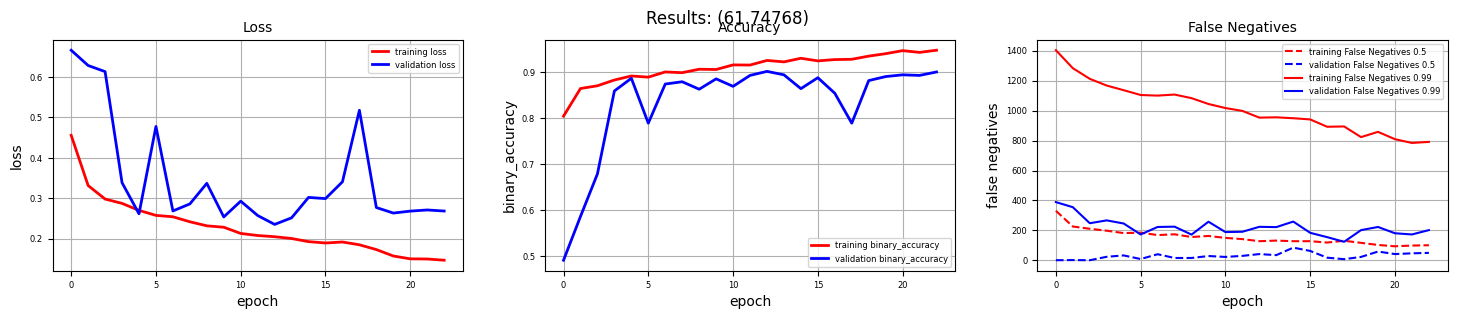

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Accuracy - (VGG19 Based model) - Threshold(0.50): Train(93.17)	Test(89.98)
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Accuracy - (VGG19 Based model) - Threshold(0.90): Train(87.65)	Test(86.02)
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Accuracy - (VGG19 Based model) - Threshold(0.99): Train(72.40)	Test(72.22)
VGG19 Based model	threshold:	0.50	Train:	93.17	Test:	89.98)
VGG19 Based model	threshold:	0.90	Train:	87.65	Test:	86.02)
VGG19 Based model	threshold:	0.99	Train:	72.40	Test:	72.22)


In [20]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

training_history, training_time = train_malaria_model(
    model=malaria_model_vgg19,
    X_train_input=X_train_copy, y_train_input=y_train_copy,
    description=f"{getattr(malaria_model_vgg19, 'howest', 'xx')}",
    verbose=1,
)
plot_history(training_history, training_time)  

collected_results = []
for threshold in [0.5, 0.9, 0.99]:
    collected_results.append(
        collect_accuracy(
            model=malaria_model_vgg19,
            X_train_input=X_train_copy, y_train_input=y_train_copy,
            X_test_input=X_test_copy, y_test_input=y_test_copy,
            decision_boundary=threshold,
            verbose=1,
        )
    )
# Summary
for n, t, train_a, test_a in collected_results:
    print(f"{n}\tthreshold:\t{t:.2f}\tTrain:\t{train_a:.2f}\tTest:\t{test_a:.2f})")

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
AUC: 0.9815


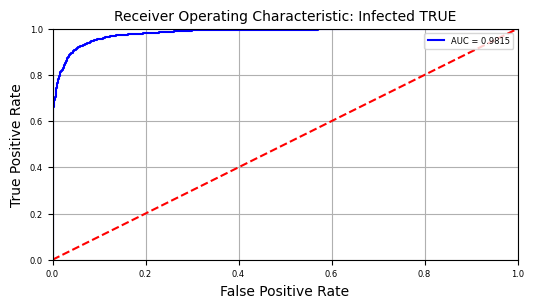

Training Set - Treshold(0.5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2000
           1       0.93      0.93      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000

confusion matrix
[[1866  134]
 [ 139 1861]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 93.175


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.9347 - false_negatives_50pct: 61.4286 - false_negatives_99pct: 544.5793 - false_positives_50pct: 65.2619 - false_positives_99pct: 0.8175 - loss: 0.1655 - precision_20: 0.9305 - true_negatives_50pct: 958.6031 - true_negatives_99pct: 1023.0476 - true_positives_50pct: 946.4524 - true_positives_99pct: 463.3016
binary_accuracy: 0.9317499995231628
false_negatives_50pct: 139.0
false_negatives_99pct: 1103.0
false_positives_50pct: 134.0
false_positives_99pct: 1.0
loss: 0.17279379069805145
precision_20: 0.9328320622444153
true_negatives_50pct: 1866.0
true_negatives_99pct: 1999.0
true_positives_50pct: 1861.0
true_positives_99pct: 897.0


'-----------------------------------------'

Test Set - Treshold(0.5)
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2000
           1       0.91      0.89      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

confusion matrix
[[1829  171]
 [ 230 1770]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 89.97500000000001


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.8994 - false_negatives_50pct: 112.0238 - false_negatives_99pct: 550.9445 - false_positives_50pct: 94.0635 - false_positives_99pct: 3.0079 - loss: 0.2609 - precision_20: 0.9005 - true_negatives_50pct: 931.4207 - true_negatives_99pct: 1022.4762 - true_positives_50pct: 894.2381 - true_positives_99pct: 455.3175
binary_accuracy: 0.8997499942779541
false_negatives_50pct: 230.0
false_negatives_99pct: 1106.0
false_positives_50pct: 171.0
false_positives_99pct: 5.0
loss: 0.2537650167942047
precision_20: 0.91190105676651
true_negatives_50pct: 1829.0
true_negatives_99pct: 1995.0
true_positives_50pct: 1770.0
true_positives_99pct: 894.0


'-----------------------------------------'

'----------------------------------------------------------------------------------'

Training Set - Treshold(0.99)
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      2000
           1       1.00      0.45      0.62      2000

    accuracy                           0.72      4000
   macro avg       0.82      0.72      0.70      4000
weighted avg       0.82      0.72      0.70      4000

confusion matrix
[[1999    1]
 [1103  897]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 72.39999999999999


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.9347 - false_negatives_50pct: 61.4286 - false_negatives_99pct: 544.5793 - false_positives_50pct: 65.2619 - false_positives_99pct: 0.8175 - loss: 0.1655 - precision_20: 0.9305 - true_negatives_50pct: 958.6031 - true_negatives_99pct: 1023.0476 - true_positives_50pct: 946.4524 - true_positives_99pct: 463.3016
binary_accuracy: 0.9317499995231628
false_negatives_50pct: 139.0
false_negatives_99pct: 1103.0
false_positives_50pct: 134.0
false_positives_99pct: 1.0
loss: 0.17279379069805145
precision_20: 0.9328320622444153
true_negatives_50pct: 1866.0
true_negatives_99pct: 1999.0
true_positives_50pct: 1861.0
true_positives_99pct: 897.0


'-----------------------------------------'

Test Set - Treshold(0.99)
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Scikit learn metrics
classification report
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      2000
           1       0.99      0.45      0.62      2000

    accuracy                           0.72      4000
   macro avg       0.82      0.72      0.70      4000
weighted avg       0.82      0.72      0.70      4000

confusion matrix
[[1995    5]
 [1106  894]]


'    p0 p1'

'a0: TN FP'

'a1: FN TP'

Accuracy score: 72.225


''

Tensorflow evaluate
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.8994 - false_negatives_50pct: 112.0238 - false_negatives_99pct: 550.9445 - false_positives_50pct: 94.0635 - false_positives_99pct: 3.0079 - loss: 0.2609 - precision_20: 0.9005 - true_negatives_50pct: 931.4207 - true_negatives_99pct: 1022.4762 - true_positives_50pct: 894.2381 - true_positives_99pct: 455.3175
binary_accuracy: 0.8997499942779541
false_negatives_50pct: 230.0
false_negatives_99pct: 1106.0
false_positives_50pct: 171.0
false_positives_99pct: 5.0
loss: 0.2537650167942047
precision_20: 0.91190105676651
true_negatives_50pct: 1829.0
true_negatives_99pct: 1995.0
true_positives_50pct: 1770.0
true_positives_99pct: 894.0


'-----------------------------------------'

'=================================================================================='

In [21]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC

# Hier zijn enkele vergelijkingen gemaakt met de metrics in sklearn en tensorflow(keras)
# Plot ROC
plot_roc_curve(model=malaria_model_vgg19, X_test_input=X_train, y_test_input=y_train)

# Metrics on the training set
print_binary_metrics(model=malaria_model_vgg19, X_test_input=X_train, y_test_input=y_train, decision_boundary=0.5, title="Training Set")
# Metrics on the test set
print_binary_metrics(model=malaria_model_vgg19, X_test_input=X_test, y_test_input=y_test, decision_boundary=0.5, title="Test Set")
display("----------------------------------------------------------------------------------")

# Metrics on the training set
print_binary_metrics(model=malaria_model_vgg19, X_test_input=X_train, y_test_input=y_train, decision_boundary=0.99, title="Training Set")
# Metrics on the test set
print_binary_metrics(model=malaria_model_vgg19, X_test_input=X_test, y_test_input=y_test, decision_boundary=0.99, title="Test Set")
display("==================================================================================")

### Conclusies transfer learning experiment

Alhoewel de dataset volledig balanced is, zie ik toch een probleem bij het ontdekken van false negatives.
(ik weet alleen niet waarom...)
Eventueel kunnen afrondingsfouten een invloed hebben bij het grote aantal bewerkingen.
TODO: in plaats (0,1) classificatie een (-1,1) classificatie gebruiken

Na wijziging van de Flatten layer in GlobalAveragePooling2D zie ik een beter verloop van het aantal false negatives, maar nog steeds niet voldoende overtuigend.

---

---
## Face recognition

Train een eigen CNN dat als taak heeft een zo accuraat mogelijke gezichtsherkenning uit te voeren op een gezichtsdataset van celebrities.

Er zijn twee gezichtsdatasets beschikbaar:

'./Face_Recognition/15_Classes' bevat gezichten van 15 verschillende celbrities.
'./Face_Recognition/100_Classes' bevat gezichten van 100 verschillende celebrities.

Werk in eerste instantie met de 15_classes dataset. 


### 15 classes dataset - eigen CNN

### Poging 1

Even de data onderzoeken

In [22]:
# Inlezen en preprocessen van de afbeeldingen
# nr_of_images = 5000
image_size = 100
input_shape=(image_size, image_size, 3)

faces = []
labels = []
# read infected train_images
path = './Face_Recognition/15_Classes'
valid_images = [".jpg",".gif",".png"]
for f in os.listdir(path)[:]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    faces.append(im)
    #s = re.sub('[0-9]\w+', '', f)
    s = os.path.splitext(f)[0]
    s = ''.join([i for i in s if not i.isdigit()])
    s = s.replace("_", "")
    labels.append(s)

In [23]:
(faces[1].shape)

(100, 100, 3)

In [24]:
print(type(faces[0]))
X_train, y_train, X_test, y_test = train_test_split(faces, labels, test_size=0.3, random_state=101, shuffle=True) 

<class 'numpy.ndarray'>


['Alvaro Morte', 'alycia debnam carey face', 'anne hathaway', 'anne hathaway', 'alycia debnam carey face', 'Alvaro Morte', 'barbara palvin face', 'Brenton Thwaites', 'alexandra daddario', 'Aaron Paul']
(100, 100, 3)


alexandra daddario          165
anne hathaway               151
amber heard face            151
alycia debnam carey face    144
barbara palvin face         142
Brenton Thwaites            130
Amanda Crew                 118
Amaury Nolasco              113
Alvaro Morte                 91
bellamy blake face           89
Aaron Paul                   86
bill gates                   86
Benedict Cumberbatch         81
Betsy Brandt                 68
Anna Gunn                    66
Name: count, dtype: int64

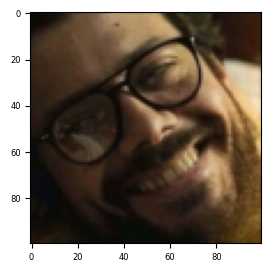

In [25]:
# Creëer een training set en test set. Zorg ervoor dat 30 procent van de afbeeldingen in de test set zitten.
print(labels[0:10])
print(faces[0].shape)
plt.imshow(faces[0])

xx = pd.Series(data=labels)
xx.unique()
xx.value_counts()

### Poging 2

De functie `ImageDataGenerator` is deprecated, maar is nog steeds aanwezig om dat er teveel gebruik van wordt gemaakt.
Er wordt aangeraden om met tf.data.Dataset te werken.

Vandaar deze poging


In [26]:
# Data Reading
def get_label(file_path):
    # Extract the label from the filename
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print(type(file_path), file_path)
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    return tf.strings.split(file_path, os.sep)[-1]

def get_label_2(file_path):
    # Extract the filename from the file path
    print("yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy")
    print(type(file_path), file_path)
    print("YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY")
    filename = tf.strings.split(file_path, os.sep)[-1]
    # Remove specific characters (e.g., remove underscores) and transform to uppercase
    name = tf.strings.regex_replace(filename, '_|.jpg', '')
    cleaned_name = tf.strings.regex_replace(name, '[0-9]', '')
    label = tf.strings.upper(cleaned_name)
    return label

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [128, 128])

def process_path(file_path):
    label = get_label_2(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def load_dataset(data_dir):
    # Get list of all image file paths
    list_ds = tf.data.Dataset.list_files(str(Path(data_dir) / '*.jpg'))
    # Map the process_path function to each file path
    labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    return labeled_ds

    # Data display
def show_examples(dataset, num_examples=5, times=5):
    plt.figure(figsize=(10, 10))
    for t in range(times):
        for i, (image, label) in enumerate(dataset.take(num_examples)):
            ax = plt.subplot(1, num_examples, i + 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(label.numpy().decode('utf-8'))
            plt.title(f"{label.numpy().decode('utf-8')}\n{image.numpy().astype("uint8").shape}")
            plt.axis("off")
        plt.show()
        display("-----------------")
def show_batch_examples_orig(dataset, num_batches=1):
    plt.figure(figsize=(10, 10))
    for batch in dataset.take(num_batches):
        images, labels = batch
        for i in range(len(images)):
            ax = plt.subplot(5, 10, i + 1)# Adjust the subplot grid size as needed            
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(labels[i].numpy().decode('utf-8'))
            plt.axis("off")
        plt.show()

def show_batch_examples(dataset, num_batches=1):
    b = 0
    plt.figure(figsize=(10, 10))
    for batch in dataset.take(num_batches):
        print(f"BATCH {b}")
        images, labels = batch
        # for i in range(len(images)):
        print("Len images: ", len(images))
        for i, image in enumerate(images):
            ax = plt.subplot(4, 8, i + 1)  # Adjust the subplot grid size as needed
            # display(images[i].numpy().astype("uint8"))
            print(labels[i])
            display(images[i].numpy().astype("uint8").shape)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"{labels[i].numpy().decode('utf-8')}\n{images[i].numpy().astype("uint8").shape}")
        plt.show()
        b = b + 1



### Poging 3

Hier worden de files met de images naar een structuur verhuisd die het voor keras gemakkelijk maakt om de data in te lezen en te catalogeren.

De function loopt over de verschillende files,
-   haalt vervolgens de naam(=category) uit de filename
-   en creeert een structure zoals verwacht in de tf.keras.preprocessing.image_dataset_from_directory.

        (name placeholder: f1_c1 == eerste file van eerste category)
        root
          - cat 1
            - f1_c1.jpg
              f2_c1.jpg
          - cat 2
            - f1_c2..jpg
              f2_c2.jpg

- er wordt een selectie gemaakt voor de training set en voor de test set
- twee basisdirectories (train en test) worden gecreeerd

In [27]:
def create_keras_compatible_structure(source_dir, target_dir):
    def get_name(filename):
        VALID_IMAGE_FILE_EXTENSIONS = [".jpg"]
        name, ext = os.path.splitext(filename)
        if ext not in VALID_IMAGE_FILE_EXTENSIONS:
            return None

        name.replace(ext, "")
        name = re.sub(r'[^a-zA-Z\s]', "", name)
        name = name.strip()
        name = name.replace(" ", "_")
        return name

    def categorize_files(data_dir):
        files = os.listdir(data_dir)
        df_files = pd.DataFrame(files, columns=['filename'])
        df_files["name"] = df_files["filename"].apply(get_name)
        df_files = df_files[df_files["name"].notna()]

        categories = df_files["name"].unique()
        df_test_files = df_files.sample(frac=0.25,  random_state=101 )
        df_train_files = df_files.drop(df_test_files.index)

        return df_train_files, df_test_files, categories

    df_train_files, df_test_files, categories = categorize_files(source_dir)

    for d in categories:
        os.makedirs(os.path.join(target_dir, "train", d), exist_ok=True)
        os.makedirs(os.path.join(target_dir, "test", d), exist_ok=True)

    # Create the train structure
    for _, entry in df_train_files.iterrows():
        # print("TRAINING", entry["filename"])
        source_path = os.path.join(source_dir, entry["filename"])
        target_path = os.path.join(target_dir, "train", entry["name"], entry["filename"])
        shutil.copy2(source_path, target_path)

    # Create the test structure
    for _, entry in df_test_files.iterrows():
        # print("TEST", entry["filename"])
        source_path = os.path.join(source_dir, entry["filename"])
        target_path = os.path.join(target_dir, "test", entry["name"], entry["filename"])
        shutil.copy2(source_path, target_path)

    return categories


In [28]:
# Preprocessing: maak de juiste directory structuur aan
DATA_DIR = Path("/home/sam/howest/howest-dl/sessie_02/opdracht/Face_Recognition/15_Classes")
WORKING_DATA_DIR = Path("/home/sam/howest/howest-dl/sessie_02/opdracht/Face_Recognition/15_Classes_keras")

categories = create_keras_compatible_structure(source_dir=DATA_DIR, target_dir=WORKING_DATA_DIR)
NUMBER_OF_CATEGORIES=categories.shape[0]
display_value("Number of categories", NUMBER_OF_CATEGORIES)
display_value("Categories all files", categories)


Number of categories: 15
Categories all files: ['Alvaro_Morte' 'alycia_debnam_carey_face' 'anne_hathaway'
 'barbara_palvin_face' 'Brenton_Thwaites' 'alexandra_daddario'
 'Aaron_Paul' 'Betsy_Brandt' 'amber_heard_face' 'bellamy_blake_face'
 'bill_gates' 'Amanda_Crew' 'Benedict_Cumberbatch' 'Amaury_Nolasco'
 'Anna_Gunn']


In [29]:
IMAGE_SIZE_WANTED = 128
IMAGE_SHAPE_WANTED = (IMAGE_SIZE_WANTED, IMAGE_SIZE_WANTED, 3)

Found 1261 files belonging to 15 classes.
Using 946 files for training.
Using 315 files for validation.
Training set
Categories found in training set: ['Aaron_Paul', 'Alvaro_Morte', 'Amanda_Crew', 'Amaury_Nolasco', 'Anna_Gunn', 'Benedict_Cumberbatch', 'Betsy_Brandt', 'Brenton_Thwaites', 'alexandra_daddario', 'alycia_debnam_carey_face', 'amber_heard_face', 'anne_hathaway', 'barbara_palvin_face', 'bellamy_blake_face', 'bill_gates']
labels size: (32, 15)
images size: (32, 128, 128, 3)
first label: (15,)
first image: (128, 128, 3)
min_pixel: 0.0
max_pixel: 250.52734375


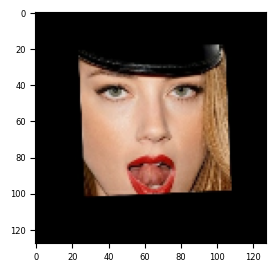

2025-04-17 00:24:07.127987: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
# Inlezen van de data in een tf.data.Dataset voor training
# split voor gebruik als validatie
TRAINING_DATA_DIR = Path(WORKING_DATA_DIR) / Path("train")

training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(TRAINING_DATA_DIR),
    labels="inferred",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE_WANTED, IMAGE_SIZE_WANTED),
    shuffle=True,
    seed=101,
    validation_split=0.25,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

display_title("Training set")
display_value("Categories found in training set", training_dataset.class_names)
 

for batch in training_dataset.take(1):
    images, labels = batch
    display_value("labels size", labels.shape)
    display_value("images size", images.shape)
    display_value("first label", labels[0].shape)
    display_value("first image", images[0].shape)
    display_value("min_pixel", np.min(images[0]))
    display_value("max_pixel", np.max(images[0]))
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.show()


Found 420 files belonging to 15 classes.
labels size: (32, 15)
images size: (32, 128, 128, 3)
first label: (15,)
first image: (128, 128, 3)
min_pixel: 0.0
max_pixel: 255.0


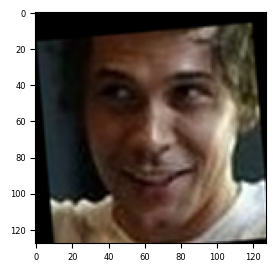

2025-04-17 00:24:07.261810: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# Inlezen van de data voor test
TEST_DATA_DIR = Path(WORKING_DATA_DIR) / Path("test")

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=str(TEST_DATA_DIR),
    labels="inferred",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE_WANTED, IMAGE_SIZE_WANTED),
    shuffle=True,
    seed=101,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

for batch in test_dataset.take(1):
    images, labels = batch
    display_value("labels size", labels.shape)
    display_value("images size", images.shape)
    display_value("first label", labels[0].shape)
    display_value("first image", images[0].shape)
    display_value("min_pixel", np.min(images[0]))
    display_value("max_pixel", np.max(images[0]))
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.show()


In [32]:
# Convolutional Neural Network Poging 1 maar te groot
model_15_1 = Sequential(
    [
        Input(shape=IMAGE_SHAPE_WANTED),
        
        ZeroPadding2D((1,1)),
        Conv2D(64, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(64, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(128, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(128, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(256, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(256, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(256, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        Conv2D(4096, (7, 7), activation="relu"),
        Dropout(0.5),
        Conv2D(4096, (1, 1), activation="relu"),
        Dropout(0.5),
        Conv2D(2622, (1, 1)),

        Flatten(),

        Activation("softmax"),
    ]
)

model_15_1.summary()

ValueError: Computed output size would be negative. Received `inputs shape=(None, 4, 4, 512)`, `kernel shape=(7, 7, 512, 4096)`, `dilation_rate=[1 1]`.

In [33]:
# Voorbereiden van de data augmentation layer(s)
# Deze zullen we toepassen de training_dataset en vervolgens bij de data toevoegen
# Het ideaal zou zijn dat dit "oneindig" kan doorgaan, maar ik heb ig niet gevonden hoe
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

NameError: name 'keras' is not defined

In [34]:
# Convolutional Neural Network Poging 2, weglaten van een een aantal conv blokken
model_15_2 = Sequential(
    [
        Input(shape=IMAGE_SHAPE_WANTED),

        # Preprocessing
        Rescaling(1.0 / 255),

        # Concolutoinal layers
        ZeroPadding2D((1,1)),
        Conv2D(64, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(64, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(128, (3, 3), activation="relu"),
        # ZeroPadding2D((1,1)),
        # Conv2D(128, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(256, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(256, (3, 3), activation="relu"),
        # ZeroPadding2D((1,1)),
        # Conv2D(256, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        # ZeroPadding2D((1,1)),
        # Conv2D(512, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        ZeroPadding2D((1,1)),
        Conv2D(512, (3, 3), activation="relu"),
        # ZeroPadding2D((1,1)),
        # Conv2D(512, (3, 3), activation="relu"),

        MaxPooling2D((2,2), strides=(2,2)),

        Conv2D(1024, (7, 7), activation="relu"),
        Dropout(0.5),
        Conv2D(512, (1, 1), activation="relu"),
        # Dropout(0.5),
        # Conv2D(2622, (1, 1)),

        # Prepare for classification
        Flatten(),

        # Classification Layers
        Dense(units=NUMBER_OF_CATEGORIES * 4),
        Activation('relu'),
    
        Dense(units=NUMBER_OF_CATEGORIES * 2),
        Activation('relu'),
    
        # Add an output layer for category classification
        Dense(units=NUMBER_OF_CATEGORIES),
        Activation('softmax')
    ]
)

model_15_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
        # metrics=['accuracy'],
        metrics=[
            # tf.keras.metrics.Accuracy(),
            tf.keras.metrics.Accuracy(),
            tf.keras.metrics.Precision(),
        ],
    )

model_15_2.summary()

ValueError: Computed output size would be negative. Received `inputs shape=(None, 4, 4, 512)`, `kernel shape=(7, 7, 512, 1024)`, `dilation_rate=[1 1]`.

In [ ]:
# Trainen
# Stop training when no further improvement is seen in the metric
verbose = 1
early_stop = EarlyStopping(
    monitor="val_loss",    # metric to monitor
    patience=10,           # stop when no improvement after 10 consecutive epochs
    mode="min",            # stop when metric stops decreasing
    restore_best_weights=True,
    verbose=verbose,             # display the actions taken
)
# Callback to save the Keras model or model weights at some frequency
checkpoint = ModelCheckpoint(
    filepath="face_15.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_freq="epoch",
    verbose=verbose,             # display the actions taken
)
# Reduce learning rate when a metric has stopped improving.
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    mode="min",
    # min_delta=0.0001,
    # cooldown=0,
    min_lr=1e-6,
    verbose=verbose,             # display the actions taken
)
# Save output to be used with tensorboard
tensorboard = TensorBoard(
    log_dir=f"logs/face_15_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

# Train the model
start_timing = time.time()
history = model_15_2.fit(
    x=training_dataset,
    batch_size=32,
    epochs=50,
    validation_data=validation_dataset,
    verbose=verbose,
    callbacks=[early_stop, reduce_lr_on_plateau, tensorboard],
)
end_timing = time.time()
training_time = end_timing - start_timing
display_value("Training Time", training_time)
plot_history(history, training_time, "C15")    


In [ ]:
# Hyperparameter tuning en image augmentation. 


**Schrijf hier jouw conclusies neer:**

### Transfer learning by means of VGG19

Hertrain een VGG19 net (of Resnet).

In [ ]:
# VGG19


**Schrijf hier jouw conclusies neer:**

### 100 classes dataset

Probeer nu classificatie te doen op de 100_classes dataset. Tranfer learning hoeft niet. Vergelijk de resultaten met de performantie op de 15_classes dataset. Evalueer en verklaar de resultaten.

In [ ]:
# Herkenning van 100 classes dataset



**Schrijf hier jouw conclusies neer:**

## Face detection 


Het doel is het ontwerpen van een CNN die met een hoge accuraatheid in staat is om gezichten te detecteren waarna rond het gezicht een bounding box getekend wordt. 
Bijvoorbeeld:
![alt text](./Jupyter_Images/Face_Detection.png) 

Doorloop de volgede stappen:
- Compileer een training set met gezichten en niet-gezichten. Online zijn verschillende gezichtsdatasets te vinden. Bijvoorbeeld: https://lionbridge.ai/datasets/5-million-faces-top-15-free-image-datasets-for-facial-recognition/ en http://shuoyang1213.me/WIDERFACE/
- Train een CNN (mag via transfer learning, maar hoeft niet) die met een hoge accuraatheid gezichten van niet-gezichten kan onderscheiden.
- Test deze CNN om een idee te hebben van de classifiation accuracy. 
- Indien de performantie voldoende hoog is kan je een sliding window detector implementeren. Dit betekent dat je de test-afbeelding meerdere keren afscant met een sliding window van verschillende groottes. Het CNN zal voor elke positie van het sliding window een classificatie doen van de subimage die onder het window is gelegen. Teken een bounding box wanneer de subimage een gezicht bevat.

Voor het tekenen van een bounding box kan de volgende code gebruikt worden:

```python
def rectangle_perimeter(r0, c0, width, height, shape=None, clip=False):
    rr, cc = [r0, r0 + width, r0 + width, r0], [c0, c0, c0 + height, c0 + height]
    return skimage.draw.polygon_perimeter(rr, cc, shape=shape, clip=clip)

# drawing the bounding box:
rr, cc = rectangle_perimeter(y, x, w, w)
image_detected[rr,cc] =255

```

Extra uitbreiding:

Probleem: omdat we de afbeelding meerdere keren afscannen, telkens met windows van verschillende grootte is het goed mogelijk dat er meerdere bounding boxes worden geteked rond hetzelfde gezicht. Zoek naar een manier om meerdere bounding boxes die bij hetzelfde gezicht horen samen te voegen tot 1 bounding box.
Een veel gebruikte techniek is Non-Maximum Suppression: https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ en https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/.

# Conclusies learning

Er kruipt veel tijd in het experimenteren met de verschillende mogelijkheden van de libraries.

Na het bekijken van de tensorflow Data en Dataset mogelijkheden, wilde ik nog graar experimenteren met de preprocessing layers.
Spijtig genoeg is het bij experimenteren gebleven.

Het toevoegen van preprocessing layers aan het model die ervoor zorgen dat het model robuster wordt en dus meer geschikt is voor industrieel gebruik lijkt me iets wat ik verder moet uitwerken.
Het moet van de losse experimenten in een afgewerkt geheel zien te komen.

Het gebruik van datasets met prefetch wilde ik gebruiken om een zeer grote input dataset aan te maken die toch verwerkt kan worden op een "gewone" computer.

---